This notebook selects and analyzes the data set used to create the plots in the first resubmitted version, with major revisions implemented.

In [1]:
from os import path
from scipy.constants import h, k as k_B, pi
import matplotlib as mpl
print(mpl.matplotlib_fname())
#import lmfit
import h5py
from kid_readout.analysis import archive, dataframe, plot_dataframe
plt.rcParams['font.size'] = 11

/home/flanigan/notebooks/mkid/2015_Flanigan/08_major_revision/matplotlibrc
updated file list


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Functions

## Data handling

In [2]:
def load_h5py(filename):
    f = h5py.File(filename)
    data = {}
    for total_turns in f.keys():
        params = dict([(str(k), v[()]) for (k, v) in zip(f[total_turns].keys(), f[total_turns].values())])
        data[int(total_turns)] = params
    return data

def add_to_dataframe(filename, df):
    prefix = path.splitext(path.split(filename)[1])[0]
    for total_turns, params in load_h5py(filename).items():
            for param, value in params.items():
                column_name = '{}_{}'.format(prefix, param)
                df.loc[df.mmw_atten_total_turns==total_turns, column_name] = value
    return df

## Analysis

In [3]:
def add_readout_power(df):
    df['Q_c'] = (df.Q**-1 - df.Q_i**-1)**-1
    df['chi_c'] = 4 * df.Q_i * df.Q_c * (df.Q_i + df.Q_c)**-2
    df['chi_g'] = (1 + (2 * df.Q * (df.noise_measurement_freq_MHz / df.f_r - 1))**2)**-1
    df['chi_a'] = 1 / 2 * df.chi_c * df.chi_g
    df['readout_power_incident'] = 1e-3 * 10**(df.power_dbm / 10)
    df['readout_power_internal'] = df.chi_a * df.readout_power_incident
    df['readout_energy_internal'] = (df.Q * df.readout_power_internal /
                                     (2 * pi * 1e6 * df.noise_measurement_freq_MHz))
    df['readout_photons_internal'] = (df.readout_energy_internal /
                                      (h * 1e6 * df.noise_measurement_freq_MHz))


def add_is_minimum(df, key, groupby, masker=None):
    def is_minimum(group):
        if masker is None:
            mask = np.ones(group.shape[0], dtype=np.bool)
        else:
            mask = masker(group)
        minimum = group[key] == group[mask][key].min()
        group.loc[mask, 'is_minimum_{}'.format(key)] = minimum
        return group
    return df.groupby(groupby).apply(is_minimum).reset_index(drop=True)


def add_is_maximum(df, key, groupby, masker=None):
    def is_maximum(group):
        if masker is None:
            mask = np.ones(group.shape[0], dtype=np.bool)
        else:
            mask = masker(group)
        maximum = group[key] == group[mask][key].max()
        group.loc[mask, 'is_maximum_{}'.format(key)] = maximum
        return group
    return df.groupby(groupby).apply(is_maximum).reset_index(drop=True)


def analyze(df, masker):
    add_readout_power(df)
    # Some of the analysis below has already been done in the data set notebook.
    # TODO: put all the analysis code in one place.
    #df = dataframe.add_finite_difference_power_response(df, 'source_power', masker=masker)
    #df['source_power_fd_NEP2_device'] = df.noise_fit_device_noise / df.source_power_fd_dX_dP**2
    df['source_power_fd_NEP2_device_err'] = df.source_power_fd_NEP2_device * ((2 * df.source_power_fd_dX_dP_err /
                                                                               df.source_power_fd_dX_dP) +
                                                                              (df.noise_fit_device_noise_err /
                                                                               df.noise_fit_device_noise))
    df['source_power_fd_NEP2_amplifier'] = df.noise_fit_amplifier_noise / df.source_power_fd_dX_dP**2
    df['source_power_fd_NEP2_amplifier_err'] = df.source_power_fd_NEP2_amplifier * ((2 * df.source_power_fd_dX_dP_err /
                                                                                     df.source_power_fd_dX_dP) +
                                                                                    (df.noise_fit_amplifier_noise_err /
                                                                                     df.noise_fit_amplifier_noise))
    #df = add_is_minimum(df, 'source_power_fd_NEP2_device', ('channel', 'mmw_atten_total_turns'), masker=masker)
    #df = add_is_maximum(df, 'source_power_fd_dX_dP', ('channel', 'mmw_atten_total_turns'), masker=masker)
    return df

## Plotting and display

In [4]:
def float_to_latex(f):
    if np.log10(f) < -15:
        unit = 'aW'
        scale = 1e6
        format_string = '{:.2f} {}'
    elif np.log10(f) < -12:
        unit = 'fW'
        scale = 1e3
        format_string = '{:.0f} {}'
    else:
        unit = 'pW'
        scale = 1
        format_string = '{:.2g} {}'
    return '{:.3g} {}'.format(1e12 * scale * f, unit)


def log_bin(df, data, n_bins):
    """
    Bin positive-frequency data spaced by frequency df into n_bins bins.
    
    The data points are assumed to correspond to frequencies [df, 2 df, 3 df, ..., data.size * df]
    """
    # The first bin edge is at df * (-1 / 2 + 0 + 1) = df / 2
    # The last bin edge is at df * (-1/2 + n_bins + data.size - n_bins + 1) = df * (data.size + 1 / 2)
    bin_edges = df * (-1 / 2 + np.arange(n_bins + 1) + 
                      np.logspace(0, np.log10(data.size - n_bins + 1), n_bins+1))
    f = df * np.arange(1, data.size + 1)
    # Values inside the given extreme bin edges are in [1, x.size]
    bin_indices = np.digitize(f, bin_edges) - 1
    binned_data = np.zeros(n_bins)
    counts = np.zeros(n_bins, dtype=np.int)
    for bin_index in range(n_bins):
        indices = bin_indices == bin_index
        binned_data[bin_index] = np.mean(data[indices])
        counts[bin_index] = np.sum(indices)
    return bin_edges, binned_data, counts

# Load data

In [5]:
compressor = archive.load_archive('/data/readout/archive/2015-07-06_compressor.npy')
# Use the data taken at the same temperature to correct for TLS noise.
compressor120mK = compressor[np.abs(compressor.sweep_primary_package_temperature - 0.120) < 0.005]
compressor120mK.shape
compressor_off = compressor120mK.sort('sweep_epoch').iloc[int(compressor120mK.shape[0] / 2):]
compressor_off.shape

(16, 99)

In [6]:
broadband = archive.load_archive('/data/readout/archive/2015-05-12_mmw_noise_broadband.npy')
#continuouswave140 = archive.load_archive('/data/readout/archive/2015-05-18_mmw_140_GHz.npy')
continuouswave148 = archive.load_archive('/data/readout/archive/2015-05-19_mmw_148_GHz.npy')
#continuouswave156 = archive.load_archive('/data/readout/archive/2015-05-20_mmw_156_GHz.npy')

# Analyze

In [7]:
masker = lambda g: ((g.timestream_modulation_duty_cycle==0) &
                    g.resonator_fit_good &
                    ~g.source_power.isnull())

In [8]:
add_readout_power(compressor_off)
broadband = analyze(broadband, masker)
#continuouswave140 = analyze(continuouswave140, masker)
continuouswave148 = analyze(continuouswave148, masker)
#continuouswave156 = analyze(continuouswave156, masker)

# Responsivity

# Noise

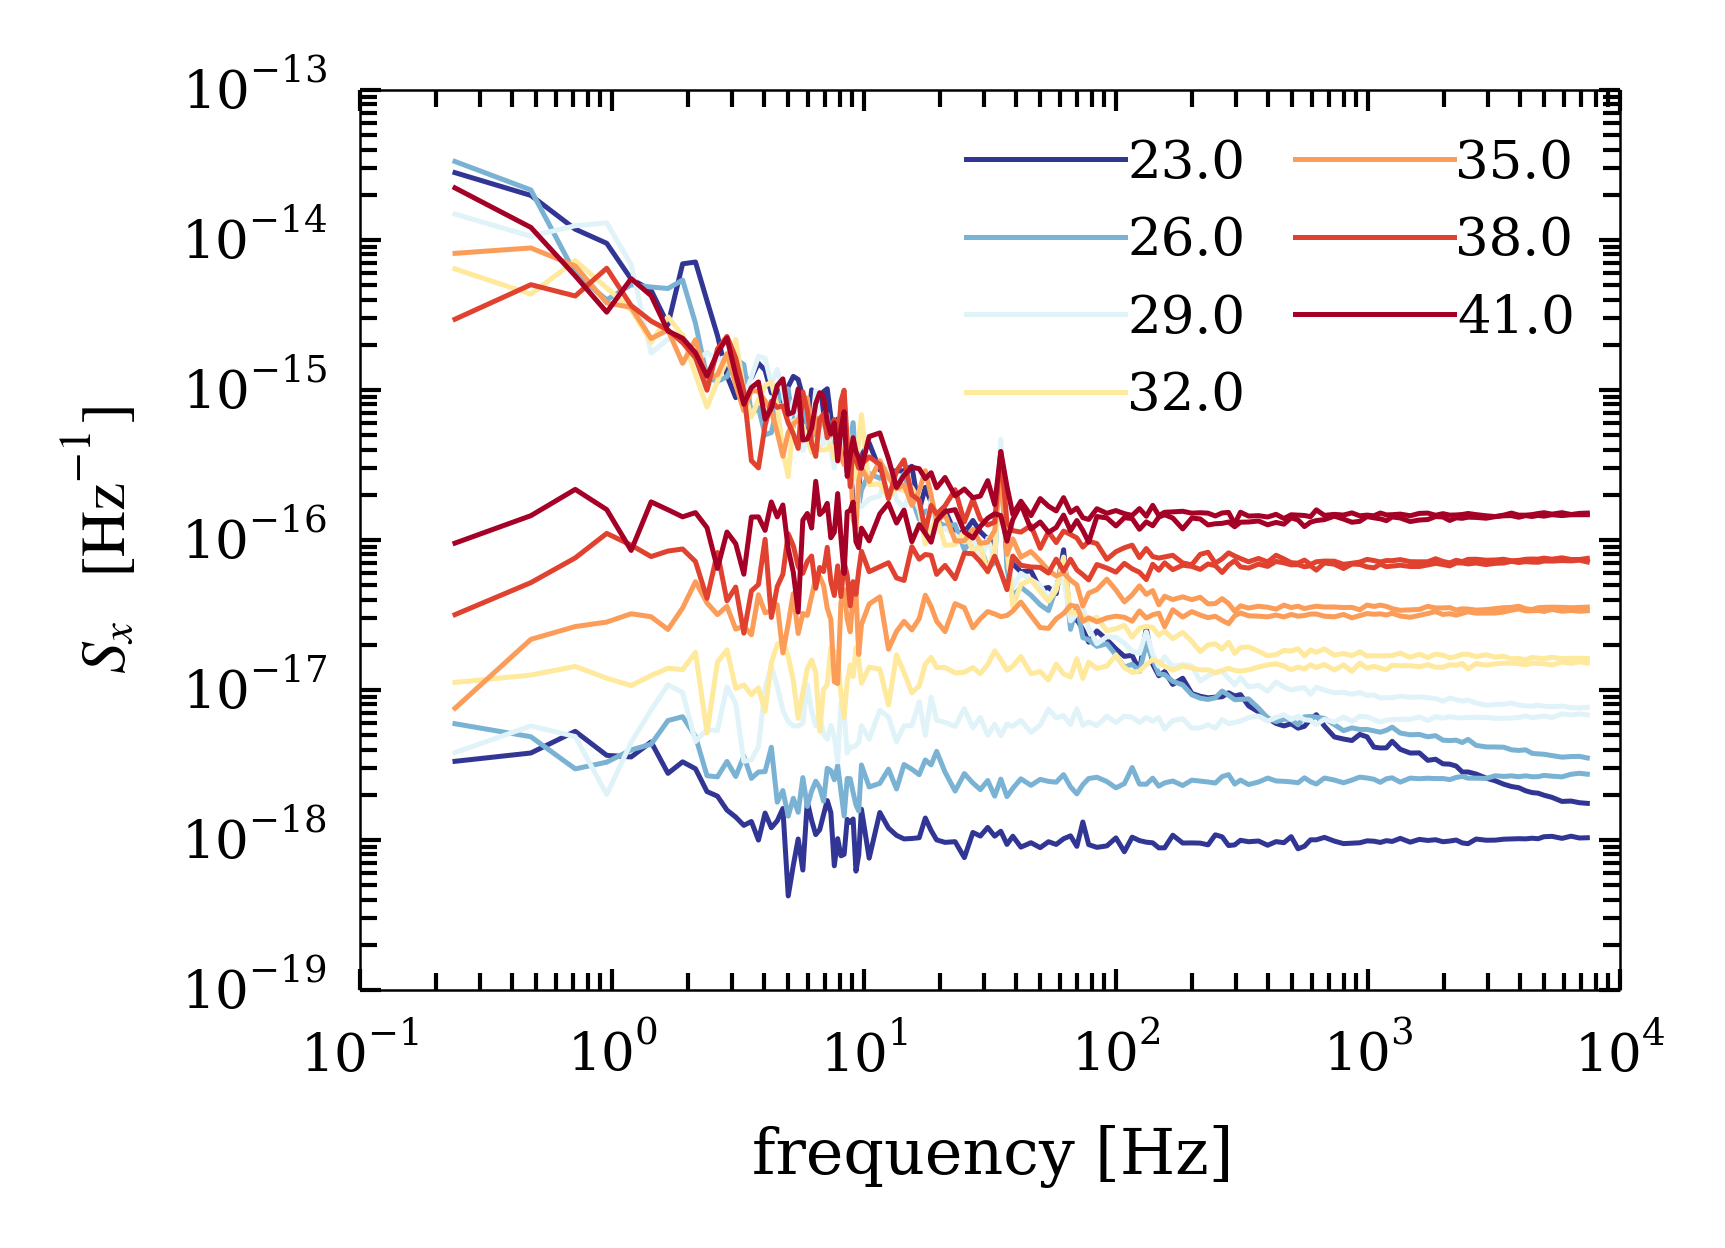

In [9]:
fig, ax = plt.subplots()
mask = (masker(continuouswave148) &
        (continuouswave148.mmw_atten_total_turns==7) &
        (continuouswave148.channel==8))
data = continuouswave148[mask]

colormap = plt.cm.RdYlBu_r
mappable = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(data.atten), max(data.atten)),
                                    cmap=colormap)
mappable.set_array(data.atten)

for index, row in data.iterrows():
    ax.loglog(row.pca_freq, row.pca_eigvals[1],
              '-', color=mappable.to_rgba(row.atten), label=str(row.atten))
    ax.loglog(row.pca_freq, row.pca_eigvals[0],
              '-', color=mappable.to_rgba(row.atten))
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('$S_x \; [\mathrm{Hz}^{-1}]$')
ax.legend(loc='upper right', ncol=2, fontsize='xx-small');
#fig.savefig('cw_7_total_turns_all_attens.pdf')

# Broadband amp-level fixed noise fitting

# NEPs

# Select single-channel data set

In [10]:
# submitted version used 148 GHz channel 8 atten 29 no tls
# use the same here

# Select constant-attenuation data
single_channel = 8
continuouswave = continuouswave148
atten = 29

# Optical frequencies
nu_cw = continuouswave.timestream_mmw_source_freq.iloc[0]
nu_bb = 150e9
print("Continuous-wave frequency {:.1f} GHz".format(1e-9 * nu_cw))

# Make further cuts
min_zbd_voltage = 0
max_zbd_voltage = np.inf  # 1e-3 * 80
bb_min_turns = 8
cw_min_turns = 8.5

bb = broadband[(broadband.channel==single_channel) &
               (broadband.atten==atten) &
               (broadband.timestream_modulation_duty_cycle==0) &
               ~broadband.source_power_X.isnull() &
               (broadband.mmw_atten_total_turns/2 <= bb_min_turns) &
               (min_zbd_voltage < broadband.zbd_voltage) &
               (broadband.zbd_voltage < max_zbd_voltage)
              ]
bb = bb.sort('source_power', ascending=False)

cw = continuouswave[(continuouswave.channel==single_channel) &
                   (continuouswave.atten==atten) &
#                  continuouswave.is_maximum_source_power_fd_dX_dP &
                   (continuouswave.timestream_modulation_duty_cycle==0) &
                   ~continuouswave.source_power_X.isnull() &
                   (continuouswave.mmw_atten_total_turns/2 <= cw_min_turns) &
                   (min_zbd_voltage < continuouswave.zbd_voltage) &
                   (continuouswave.zbd_voltage < max_zbd_voltage)
                   ]
cw = cw.sort('source_power', ascending=False)

off = compressor_off[compressor_off.channel==single_channel]

Continuous-wave frequency 148.0 GHz


In [11]:
bb.mmw_atten_total_turns

1078     6
1077     7
1076     8
1075     9
1074    10
1073    11
1072    12
1071    13
1070    14
1069    15
1068    16
Name: mmw_atten_total_turns, dtype: float64

In [12]:
cw.mmw_atten_total_turns

1077     7
1076     8
1075     9
1074    10
1073    11
1072    12
1071    13
1070    14
1069    15
1068    16
1067    17
Name: mmw_atten_total_turns, dtype: float64

In [11]:
print("Problems:")
if np.any(bb.source_power_X < 0):
    print("Broadband negative response")
if np.any(cw.source_power_X < 0):
    print("Continuous-wave negative response")
if np.any(bb.source_power_fd_dX_dP < 0):
    print("Broadband negative responsivity")
if np.any(cw.source_power_fd_dX_dP < 0):
    print("Continuous-wave negative responsivity")
if np.any(~bb.a.isnull()):
    print("Broadband nonlinearity parameter a is nonzero")
if np.any(~cw.a.isnull()):
    print("Continuous-wave nonlinearity parameter a is nonzero")
#if np.any(bb.noise_fit_fc_err / bb.noise_fit_fc > max_fractional_fc_error):
#    print("Broadband f_c error > {:.2f}".format(max_fractional_fc_error))
#if np.any(cw.noise_fit_fc_err / cw.noise_fit_fc > max_fractional_fc_error):
#    print("Continuous-wave f_c error > {:.2f}".format(max_fractional_fc_error))

Problems:


## Plot settings

In [12]:
colormap = plt.cm.RdYlBu_r
mappable_cw = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(cw.source_power), max(cw.source_power)),
                                    cmap=colormap)
mappable_cw.set_array(cw.source_power)

mappable_bb = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(bb.source_power), max(bb.source_power)),
                                    cmap=colormap)
mappable_bb.set_array(bb.source_power)

In [13]:
cw_color = 'darkgoldenrod'
bb_color = 'darkgreen'
cw_marker = 's'
bb_marker = 'o'
cw_label = "continuous-wave"  # "c-w {:.0f} GHz".format(1e-9 * cw.timestream_mmw_source_freq.iloc[0])
bb_label = "broadband"  # "bb 140-160 GHz"

Sx_scale = 1e18
noise_ylimits = (Sx_scale * 3e-20, Sx_scale * 9e-16)
noise_xlimits = (1e0, 1e4)

PS_scale = 1e6
PA_scale = 1e12
X_scale = 1e6
PS_limits = (1e-3, 1e2)
PA_limits = (8e-4, 6e1)
X_limits = (1e-1, 1e3)
NEPA_limits = (1e-18, 1e-15)
PA_line = np.logspace(np.log10(PA_limits[0]), np.log10(PA_limits[1]), 1e3) / PA_scale
to_aWrtHz = 1e18

## Max's noise fitting

In [14]:
cw.shape

(11, 141)

In [15]:
cw = add_to_dataframe('2015-12-12_fitfiles/amp_fit_cut10.h5', cw)
cw['source_power_fd_afc10_NEP2_device'] = cw.amp_fit_cut10_white * (cw.source_power_fd_dX_dP)**(-2)
cw['source_power_fd_afc10_NEP2_device_err'] = cw.source_power_fd_afc10_NEP2_device * ((2 * cw.source_power_fd_dX_dP_err /
                                                                                       cw.source_power_fd_dX_dP) +
                                                                                      (cw.amp_fit_cut10_white_std /
                                                                                       cw.amp_fit_cut10_white))

cw.shape

(11, 153)

In [16]:
cw = add_to_dataframe('2015-12-12_fitfiles/amp_fit_cut100alpha.h5', cw)
cw['source_power_fd_afc100a_NEP2_device'] = cw.amp_fit_cut100alpha_white * (cw.source_power_fd_dX_dP)**(-2)
cw['source_power_fd_afc100a_NEP2_device_err'] = cw.source_power_fd_afc100a_NEP2_device * ((2 * cw.source_power_fd_dX_dP_err /
                                                                                           cw.source_power_fd_dX_dP) +
                                                                                          (cw.amp_fit_cut100alpha_white_std /
                                                                                           cw.amp_fit_cut100alpha_white))
cw.shape

(11, 165)

In [17]:
bb = add_to_dataframe('2015-12-13_bb2/bb_fit_cut10.h5', bb)
bb['source_power_fd_afc10_NEP2_device'] = bb.bb_fit_cut10_white * (bb.source_power_fd_dX_dP)**(-2)
bb['source_power_fd_afc10_NEP2_device_err'] = bb.source_power_fd_afc10_NEP2_device * ((2 * bb.source_power_fd_dX_dP_err /
                                                                                       bb.source_power_fd_dX_dP) +
                                                                                      (bb.bb_fit_cut10_white_std /
                                                                                       bb.bb_fit_cut10_white))
bb.shape

(11, 153)

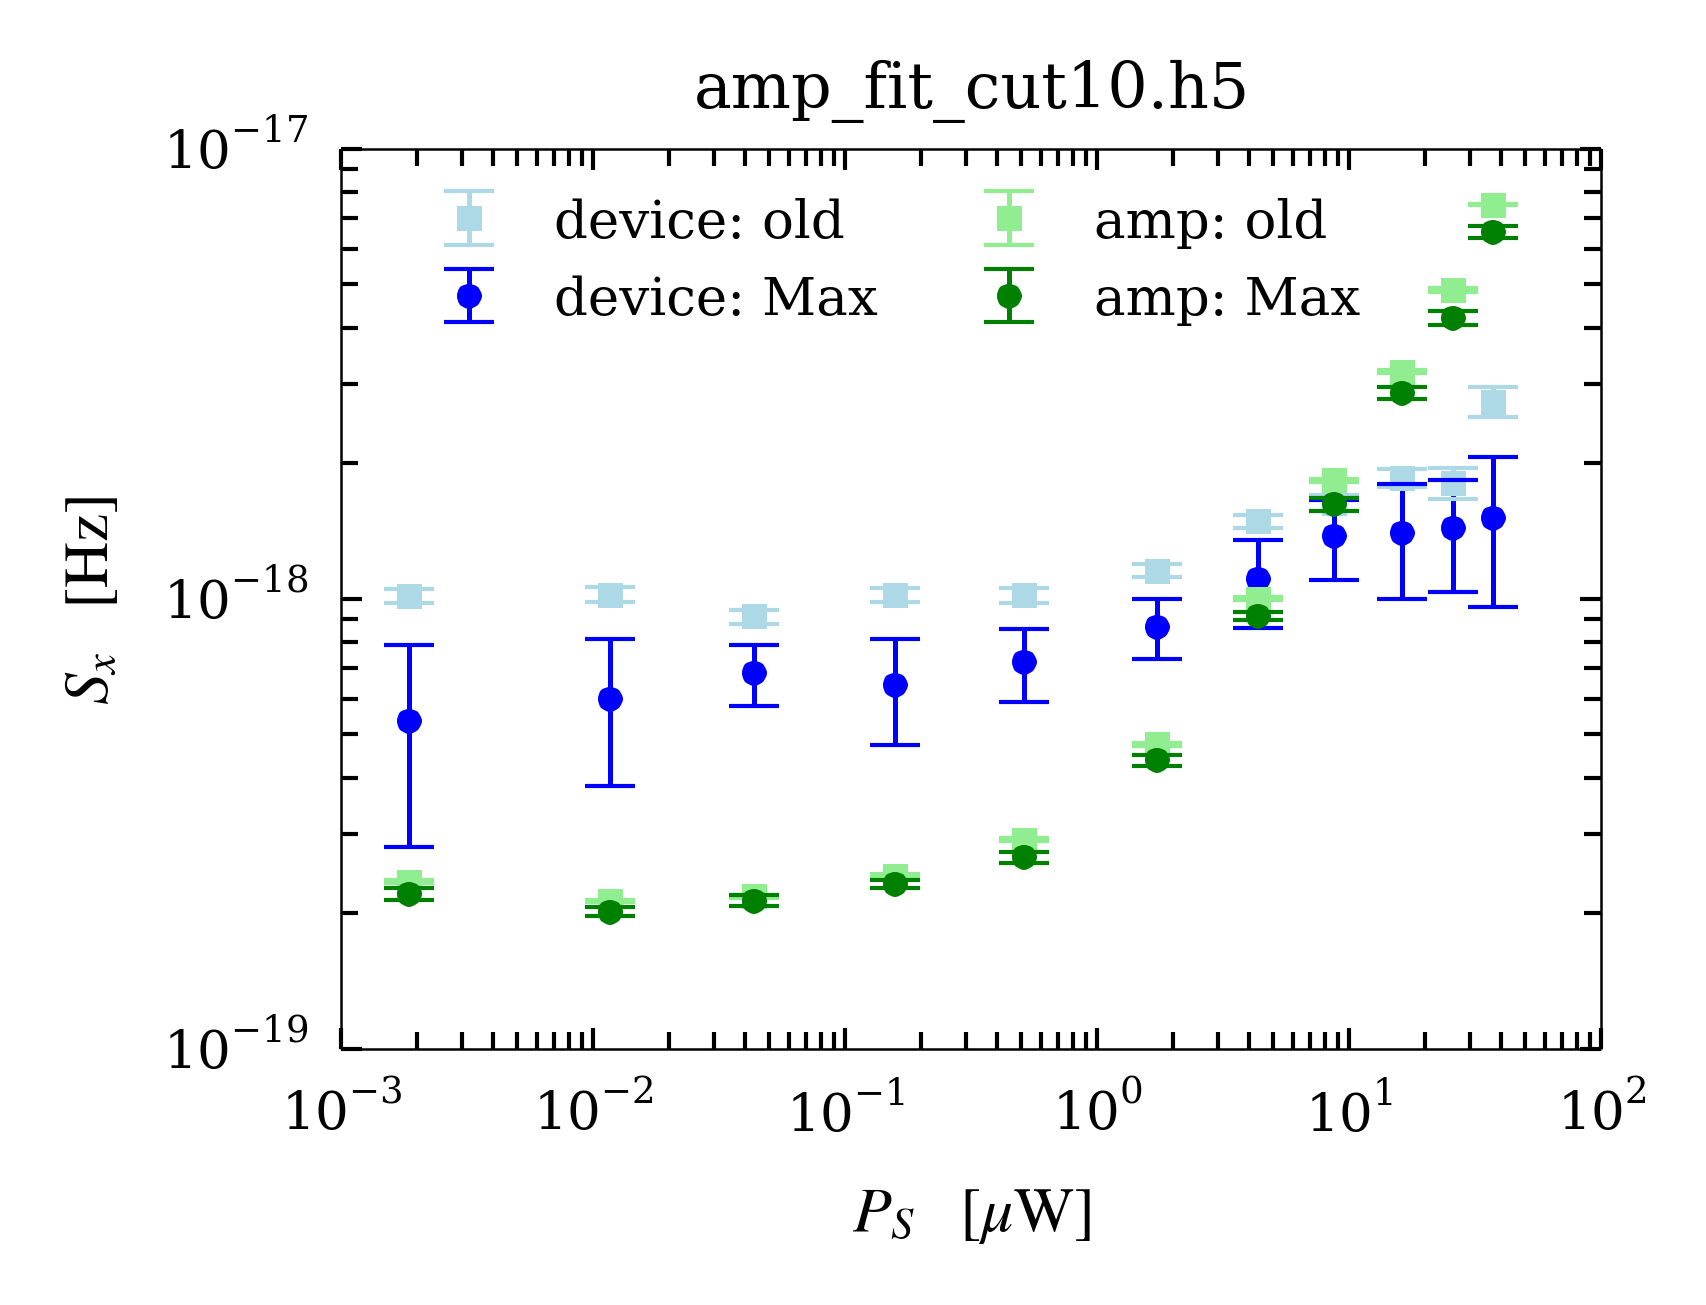

In [18]:
P_scale = 1e6

fig, ax = plt.subplots()

ax.errorbar(P_scale * cw.source_power,
            cw.noise_fit_device_noise,
            yerr=cw.noise_fit_device_noise_err,
            marker='s', linestyle='none', markeredgecolor='none', color='lightblue',
            label='device: old')

ax.errorbar(P_scale * cw.source_power,
            cw.amp_fit_cut10_white,
            yerr=cw.amp_fit_cut10_white_std,
            marker='o', linestyle='none', markeredgecolor='none', color='blue',
            label='device: Max')

ax.errorbar(P_scale * cw.source_power,
            cw.noise_fit_amplifier_noise,
            yerr=cw.noise_fit_amplifier_noise_err,
            marker='s', linestyle='none', markeredgecolor='none', color='lightgreen',
            label='amp: old')

ax.errorbar(P_scale * cw.source_power,
            cw.amp_fit_cut10_amp,
            yerr=cw.amp_fit_cut10_amp_std,
            marker='o', linestyle='none', markeredgecolor='none', color='green',
            label='amp: Max')

ax.set_ylabel('$S_x \; [\mathrm{Hz}]$')
ax.set_xlabel('$P_S \; [\mu \mathrm{W}]$')
ax.legend(loc='upper left', ncol=2, fontsize='xx-small')
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
ax.set_title('amp_fit_cut10.h5');

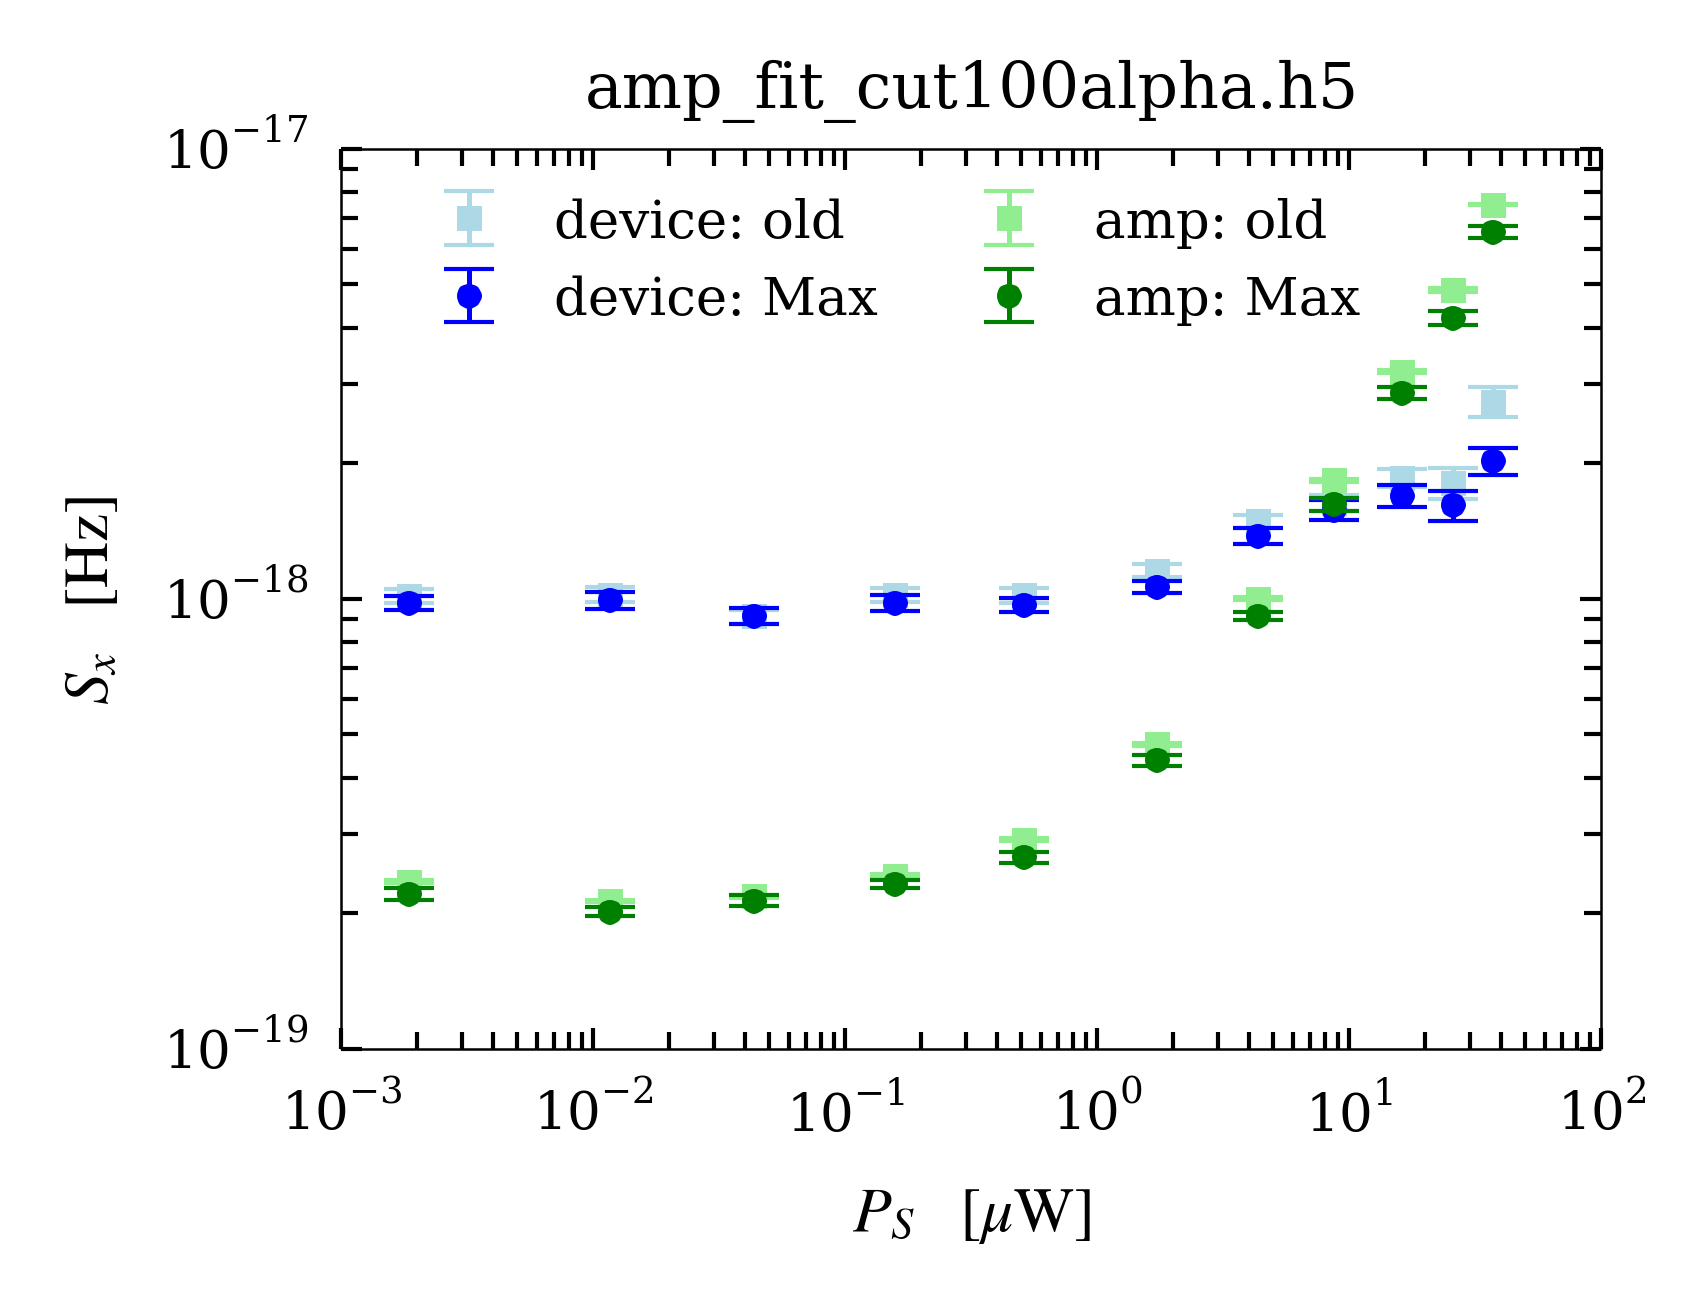

In [19]:
P_scale = 1e6

fig, ax = plt.subplots()

ax.errorbar(P_scale * cw.source_power,
            cw.noise_fit_device_noise,
            yerr=cw.noise_fit_device_noise_err,
            marker='s', linestyle='none', markeredgecolor='none', color='lightblue',
            label='device: old')

ax.errorbar(P_scale * cw.source_power,
            cw.amp_fit_cut100alpha_white,
            yerr=cw.amp_fit_cut100alpha_white_std,
            marker='o', linestyle='none', markeredgecolor='none', color='blue',
            label='device: Max')

ax.errorbar(P_scale * cw.source_power,
            cw.noise_fit_amplifier_noise,
            yerr=cw.noise_fit_amplifier_noise_err,
            marker='s', linestyle='none', markeredgecolor='none', color='lightgreen',
            label='amp: old')

ax.errorbar(P_scale * cw.source_power,
            cw.amp_fit_cut100alpha_amp,
            yerr=cw.amp_fit_cut100alpha_amp_std,
            marker='o', linestyle='none', markeredgecolor='none', color='green',
            label='amp: Max')

ax.set_ylabel('$S_x \; [\mathrm{Hz}]$')
ax.set_xlabel('$P_S \; [\mu \mathrm{W}]$')
ax.legend(loc='upper left', ncol=2, fontsize='xx-small')
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
ax.set_title('amp_fit_cut100alpha.h5');

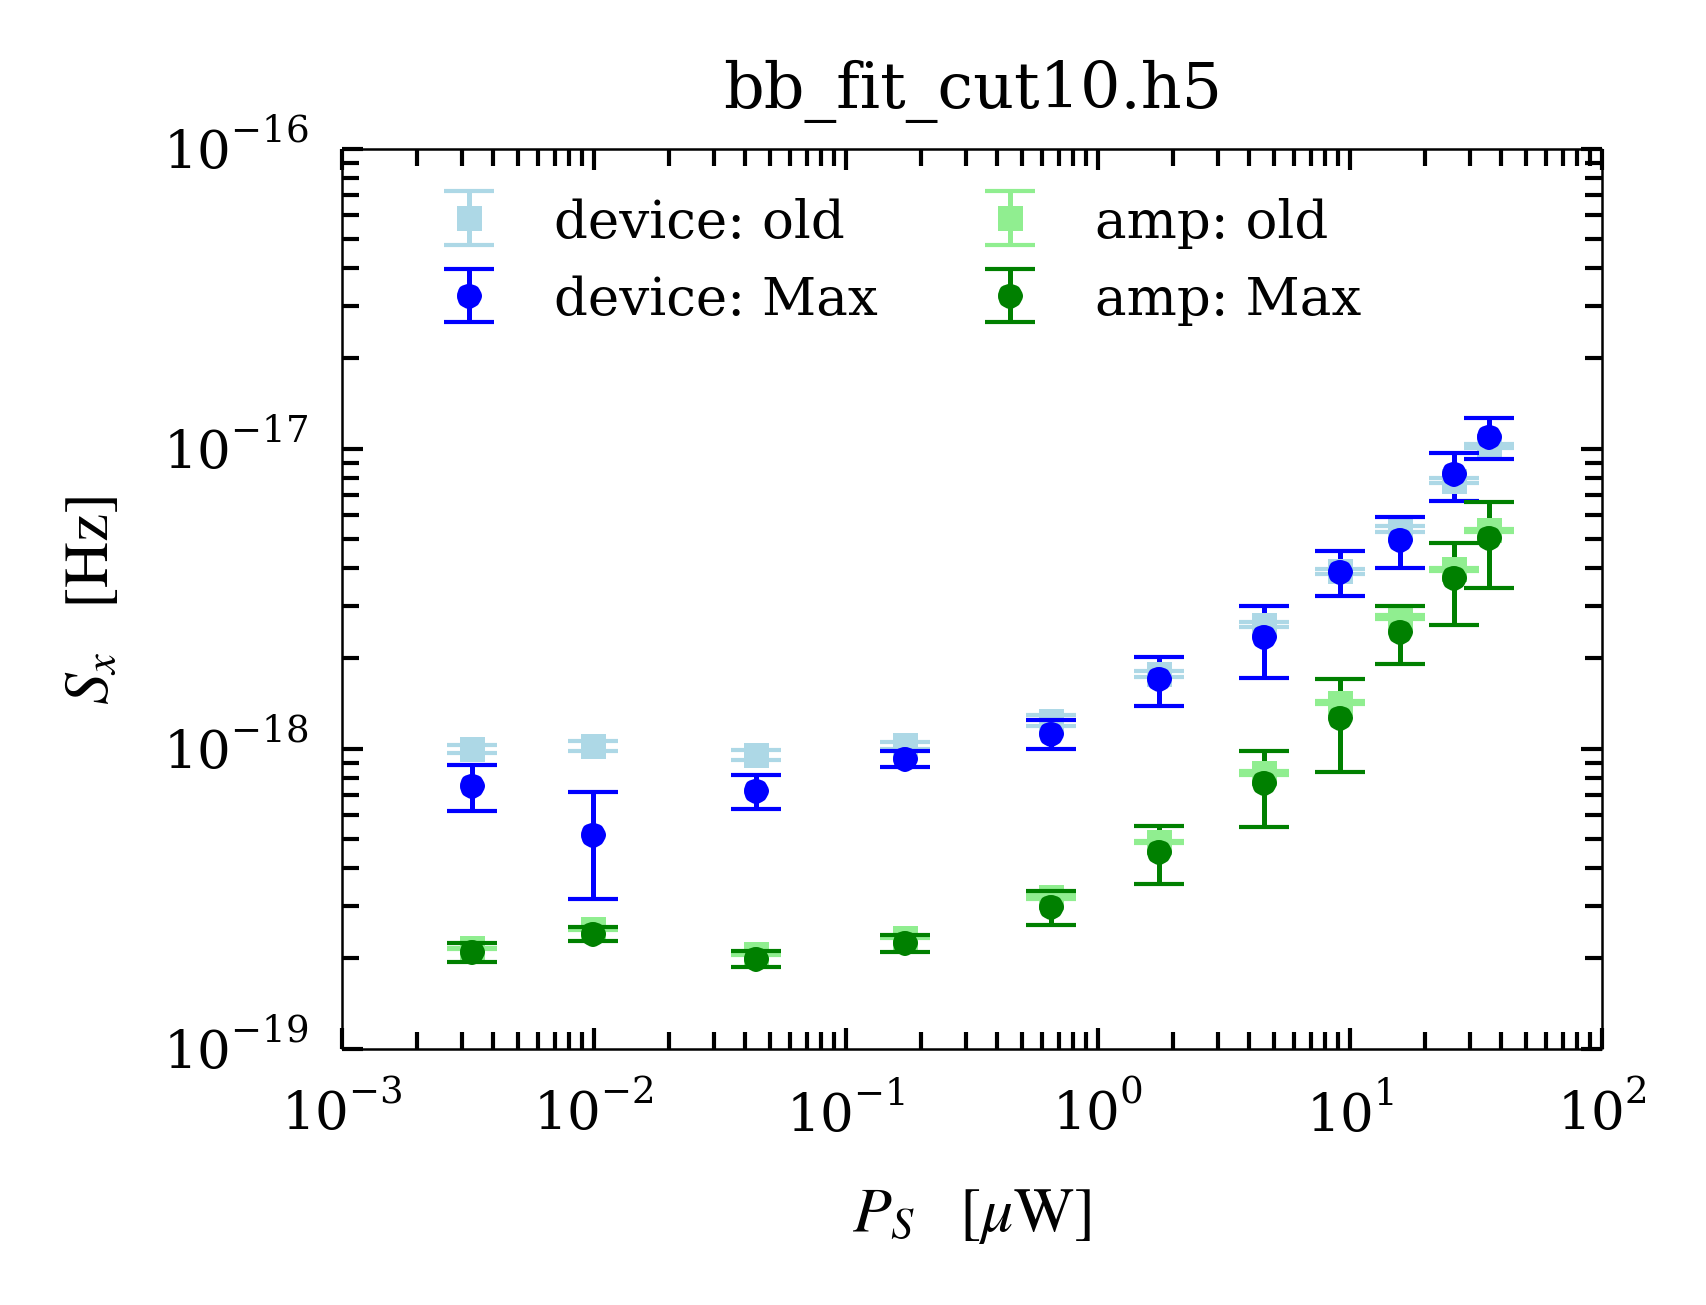

In [20]:
P_scale = 1e6

fig, ax = plt.subplots()

ax.errorbar(P_scale * bb.source_power,
            bb.noise_fit_device_noise,
            yerr=bb.noise_fit_device_noise_err,
            marker='s', linestyle='none', markeredgecolor='none', color='lightblue',
            label='device: old')

ax.errorbar(P_scale * bb.source_power,
            bb.bb_fit_cut10_white,
            yerr=bb.bb_fit_cut10_white_std,
            marker='o', linestyle='none', markeredgecolor='none', color='blue',
            label='device: Max')

ax.errorbar(P_scale * bb.source_power,
            bb.noise_fit_amplifier_noise,
            yerr=bb.noise_fit_amplifier_noise_err,
            marker='s', linestyle='none', markeredgecolor='none', color='lightgreen',
            label='amp: old')

ax.errorbar(P_scale * bb.source_power,
            bb.bb_fit_cut10_amp,
            yerr=bb.bb_fit_cut10_amp_std,
            marker='o', linestyle='none', markeredgecolor='none', color='green',
            label='amp: Max')

ax.set_ylabel('$S_x \; [\mathrm{Hz}]$')
ax.set_xlabel('$P_S \; [\mu \mathrm{W}]$')
ax.legend(loc='upper left', ncol=2, fontsize='xx-small')
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
ax.set_title('bb_fit_cut10.h5');

# Noise spectra

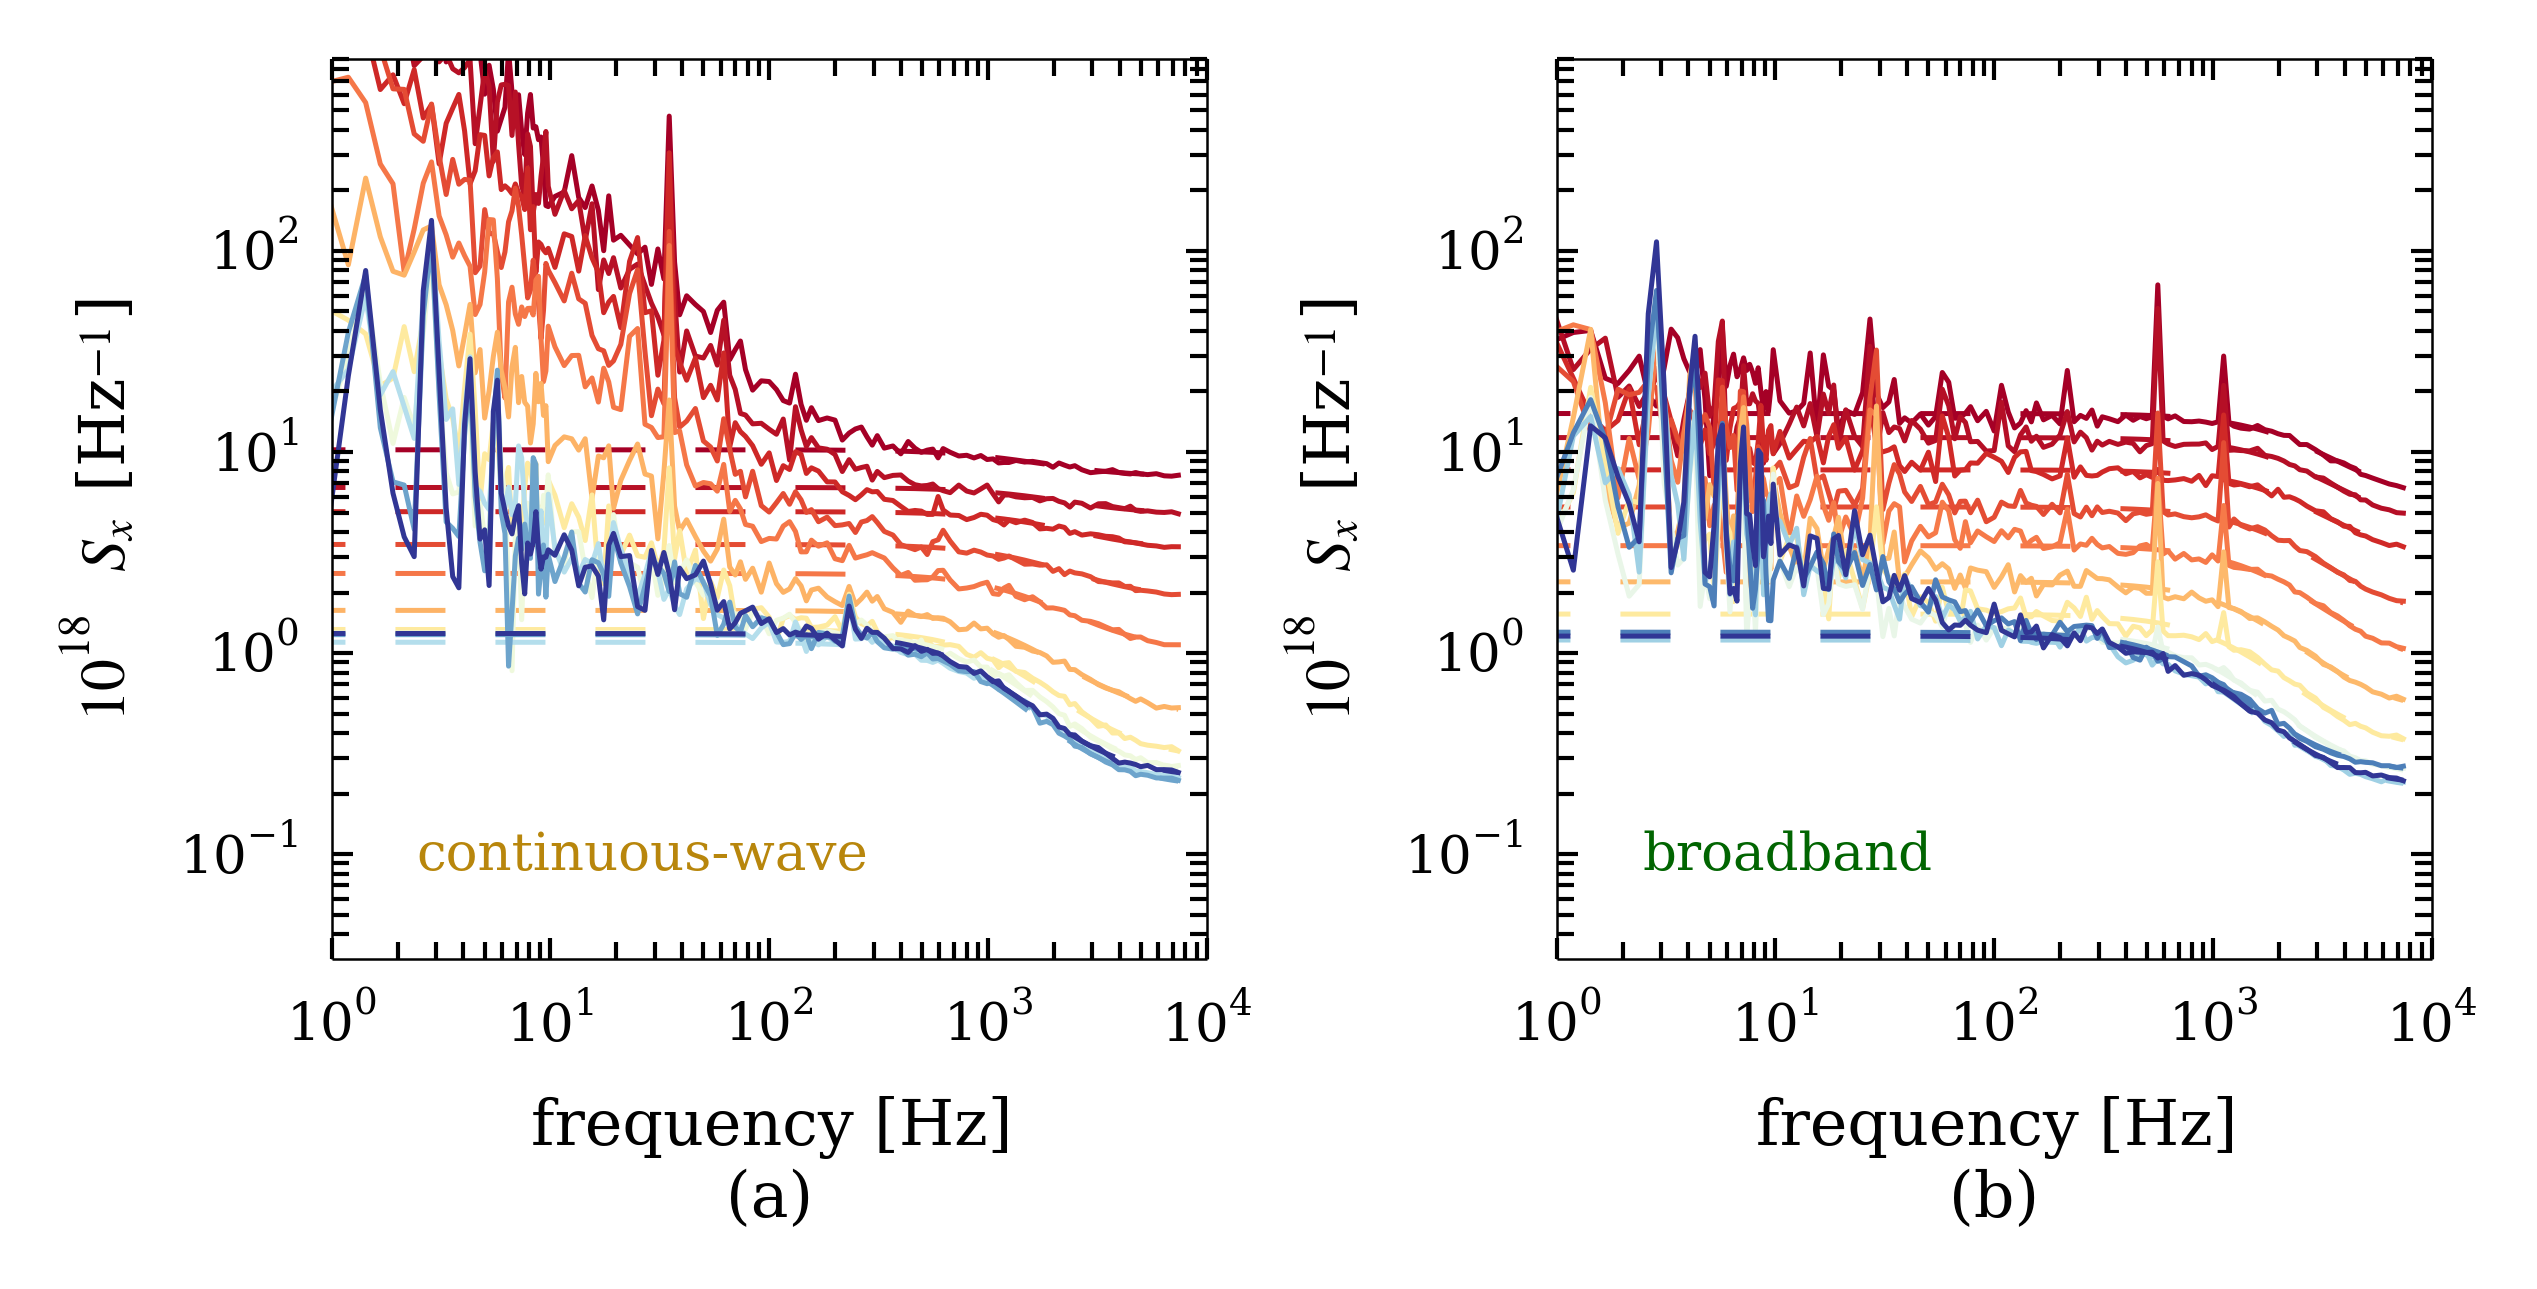

In [21]:
with plt.rc_context({'figure.subplot.wspace': 0.4,
                     'legend.numpoints': 1}):
    fig, (cw_ax, bb_ax)  = plt.subplots(ncols=2, figsize=(5, 2))

    
    # Continuous-wave
    for index, row in cw.iterrows():
        cw_ax.loglog(row.pca_freq,
                     Sx_scale * row.pca_eigvals[1],
                     color=mappable_cw.to_rgba(row.source_power), alpha=1)
#                     label=float_to_latex(eta_cw * row.source_power))
        cw_ax.loglog(row.pca_freq,
                     Sx_scale * (row.noise_fit_device_noise / (1 + (row.pca_freq / row.noise_fit_fc)**2) +
                                 row.noise_fit_amplifier_noise),
                     '--', color=mappable_cw.to_rgba(row.source_power))
    cw_ax.set_xlabel("frequency [Hz]\n(a)")
    cw_ax.set_ylabel("$10^{18} \; S_x$ [Hz$^{-1}$]")
    cw_ax.set_xlim(*noise_xlimits)
    cw_ax.set_ylim(*noise_ylimits)
#    cw_ax.legend(loc='upper right', ncol=2, fontsize=4)
    cw_ax.text(0.1, 0.1, 'continuous-wave', size='xx-small', color=cw_color, transform=cw_ax.transAxes)

    # Broadband
    for index, row in bb.iterrows():
        bb_ax.loglog(row.pca_freq,
                     Sx_scale * row.pca_eigvals[1],
                     color=mappable_bb.to_rgba(row.source_power), alpha=1)
#                     label=float_to_latex(eta_bb * row.source_power))
        bb_ax.loglog(row.pca_freq,
                     Sx_scale * (row.noise_fit_device_noise / (1 + (row.pca_freq / row.noise_fit_fc)**2) +
                                 row.noise_fit_amplifier_noise),
                     '--', color=mappable_bb.to_rgba(row.source_power))
    bb_ax.set_xlabel("frequency [Hz]\n(b)")
    bb_ax.set_ylabel("$10^{18} \; S_x$ [Hz$^{-1}$]")
    bb_ax.set_xlim(noise_xlimits)
    bb_ax.set_ylim(noise_ylimits)
#    bb_ax.legend(loc='upper left', ncol=3, fontsize=4)
    bb_ax.text(0.1, 0.1, 'broadband', size='xx-small', color=bb_color, transform=bb_ax.transAxes)


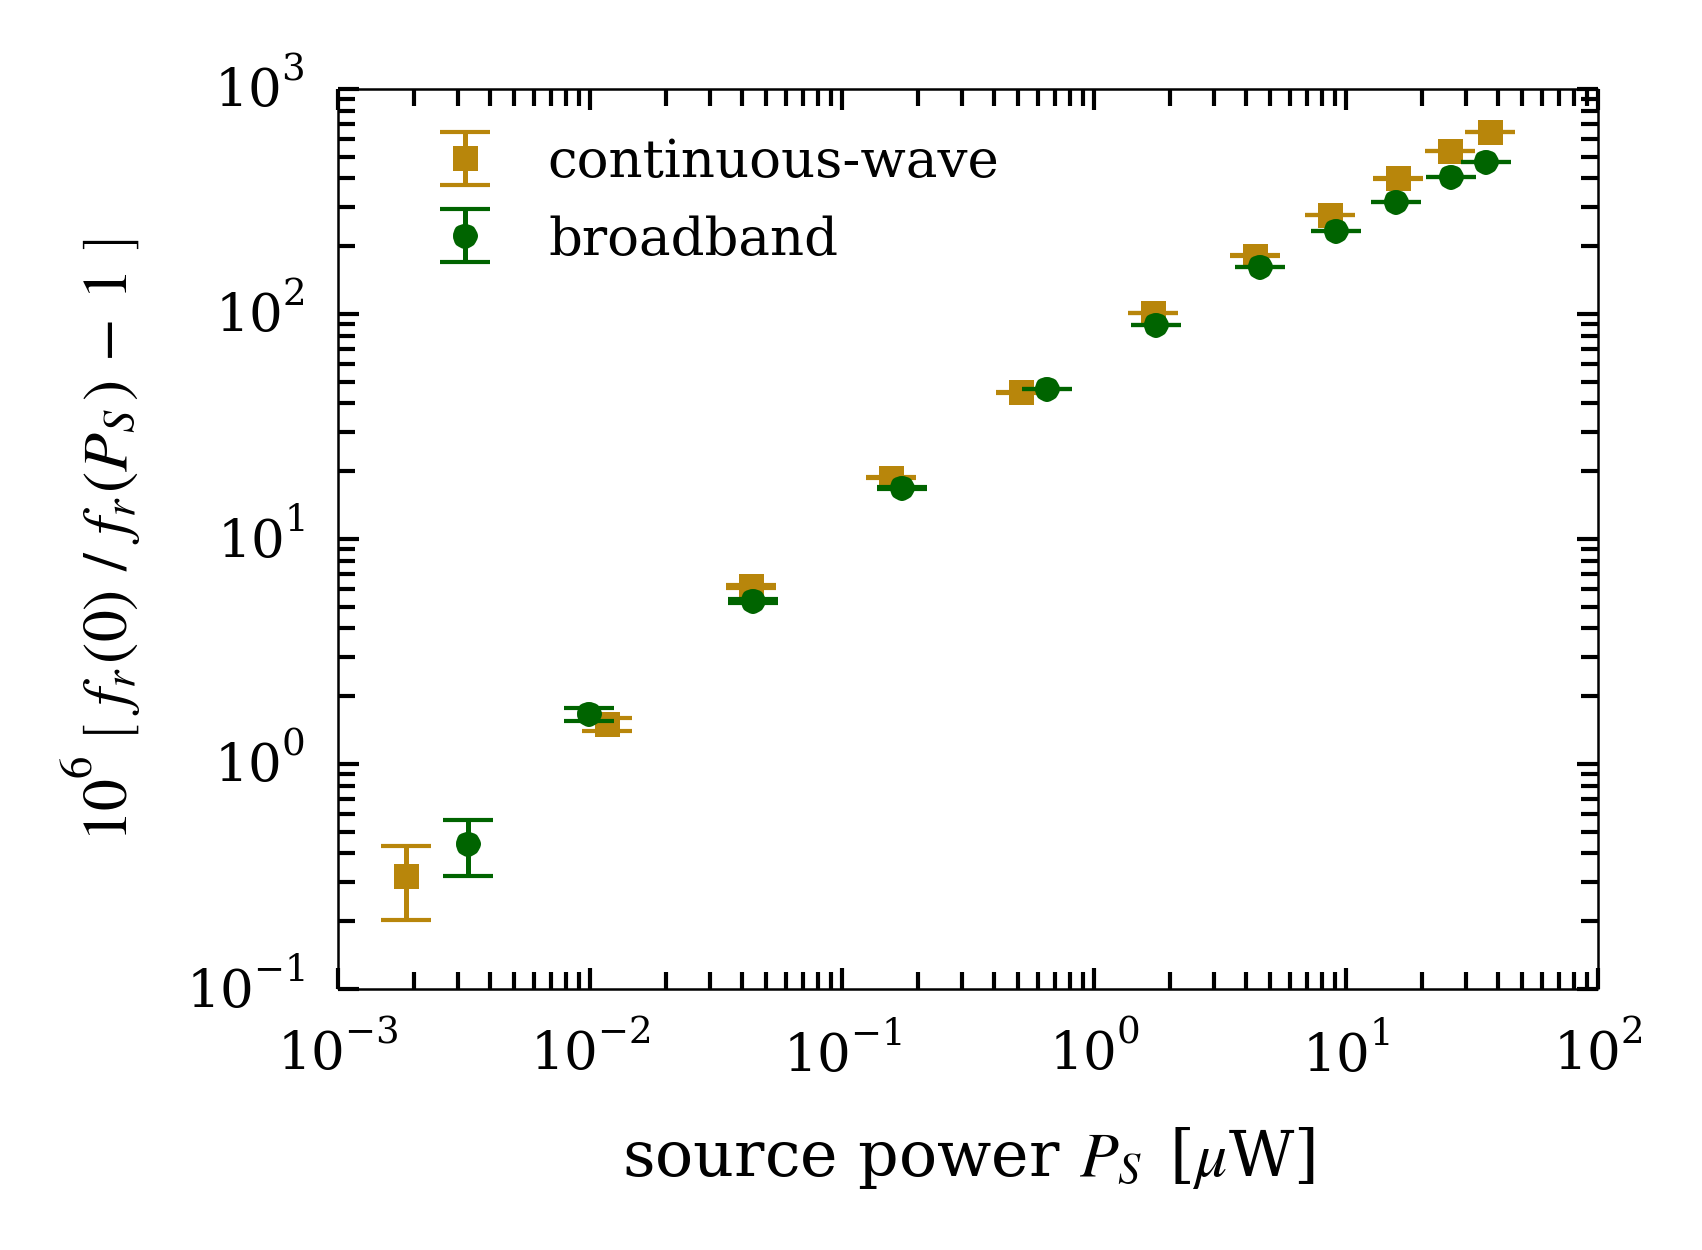

In [22]:
fig, ax = plt.subplots()

for df, color, marker, label in zip((cw, bb), (cw_color, bb_color), (cw_marker, bb_marker),
                                 (cw_label, bb_label)):
    ax.errorbar(PS_scale * df.source_power,
                X_scale * df.source_power_X,
                yerr=X_scale * df.source_power_X_err,
                marker=marker, color=color, label=label,
                linestyle='none', markeredgecolor='none')

ax.set_xlim(*PS_limits)
ax.set_ylim(*X_limits)
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
ax.set_ylabel(r'$10^6 \left[ \, f_r(0) \, / \, f_r(P_S) \, - \, 1 \, \right]$')
ax.set_xlabel('source power $P_S$ [$\mu$W]')
ax.legend(loc='best', fontsize='xx-small');

## polyfit analysis

In [23]:
cw_NEP2_key = 'source_power_fd_afc10_NEP2_device'  #'source_power_fd_NEP2_device'
bb_NEP2_key = 'source_power_fd_afc10_NEP2_device'  #'source_power_fd_NEP2_device'

In [24]:
cw_order = 1
cw_poly, cw_cov = np.polyfit(cw.source_power,
                             cw[cw_NEP2_key],
                             cw_order, w=1/cw[cw_NEP2_key+'_err'], cov=True)
eta_cw = 4 * h * nu_cw / cw_poly[-2]
print("eta = {:.4g} (1 +/- {:.2f})".format(eta_cw, np.diag(cw_cov)[-2]**(1/2) / cw_poly[-2]))
print("NEP_0 = {:.2g} W Hz^(-1/2)".format(eta_cw * cw_poly[-1]**(1/2)))

eta = 1.23e-06 (1 +/- 0.07)
NEP_0 = 5.3e-18 W Hz^(-1/2)


In [25]:
bb_order = 2
bb_poly, bb_cov = np.polyfit(bb.source_power,
                             bb[bb_NEP2_key],
                             bb_order, w=1/bb[bb_NEP2_key+'_err'], cov=True)
eta_bb = 4 * h * nu_bb / bb_poly[1]
B_bb = 2 / bb_poly[0]
print("eta = {:.4g} (1 +/- {:.2f})".format(eta_bb, np.diag(bb_cov)[1]**(1/2) / bb_poly[1]))
print("B = {:.0f} GHz (1 +/- {:.2f})".format(1e-9 * B_bb, np.diag(bb_cov)[0]**(1/2) / bb_poly[0]))
print("NEP_0 = {:.2g} W Hz^(-1/2)".format(eta_bb * bb_poly[-1]**(1/2)))

eta = 8.104e-07 (1 +/- 0.12)
B = 12 GHz (1 +/- 0.11)
NEP_0 = 4.4e-18 W Hz^(-1/2)


In [26]:
bb['eta'] = eta_bb
cw['eta'] = eta_cw
bb['B'] = B_bb
np.save('broadband.npy', bb.to_records(index=False))
np.save('continuous-wave.npy', cw.to_records(index=False))
np.save('compressor_off.npy', off.to_records(index=False))

# Delete below as much as possible: verify only

In [27]:
cw_color = 'green'
bb_color = 'brown'
cw_marker = 's'
bb_marker = 'o'
markersize = 3

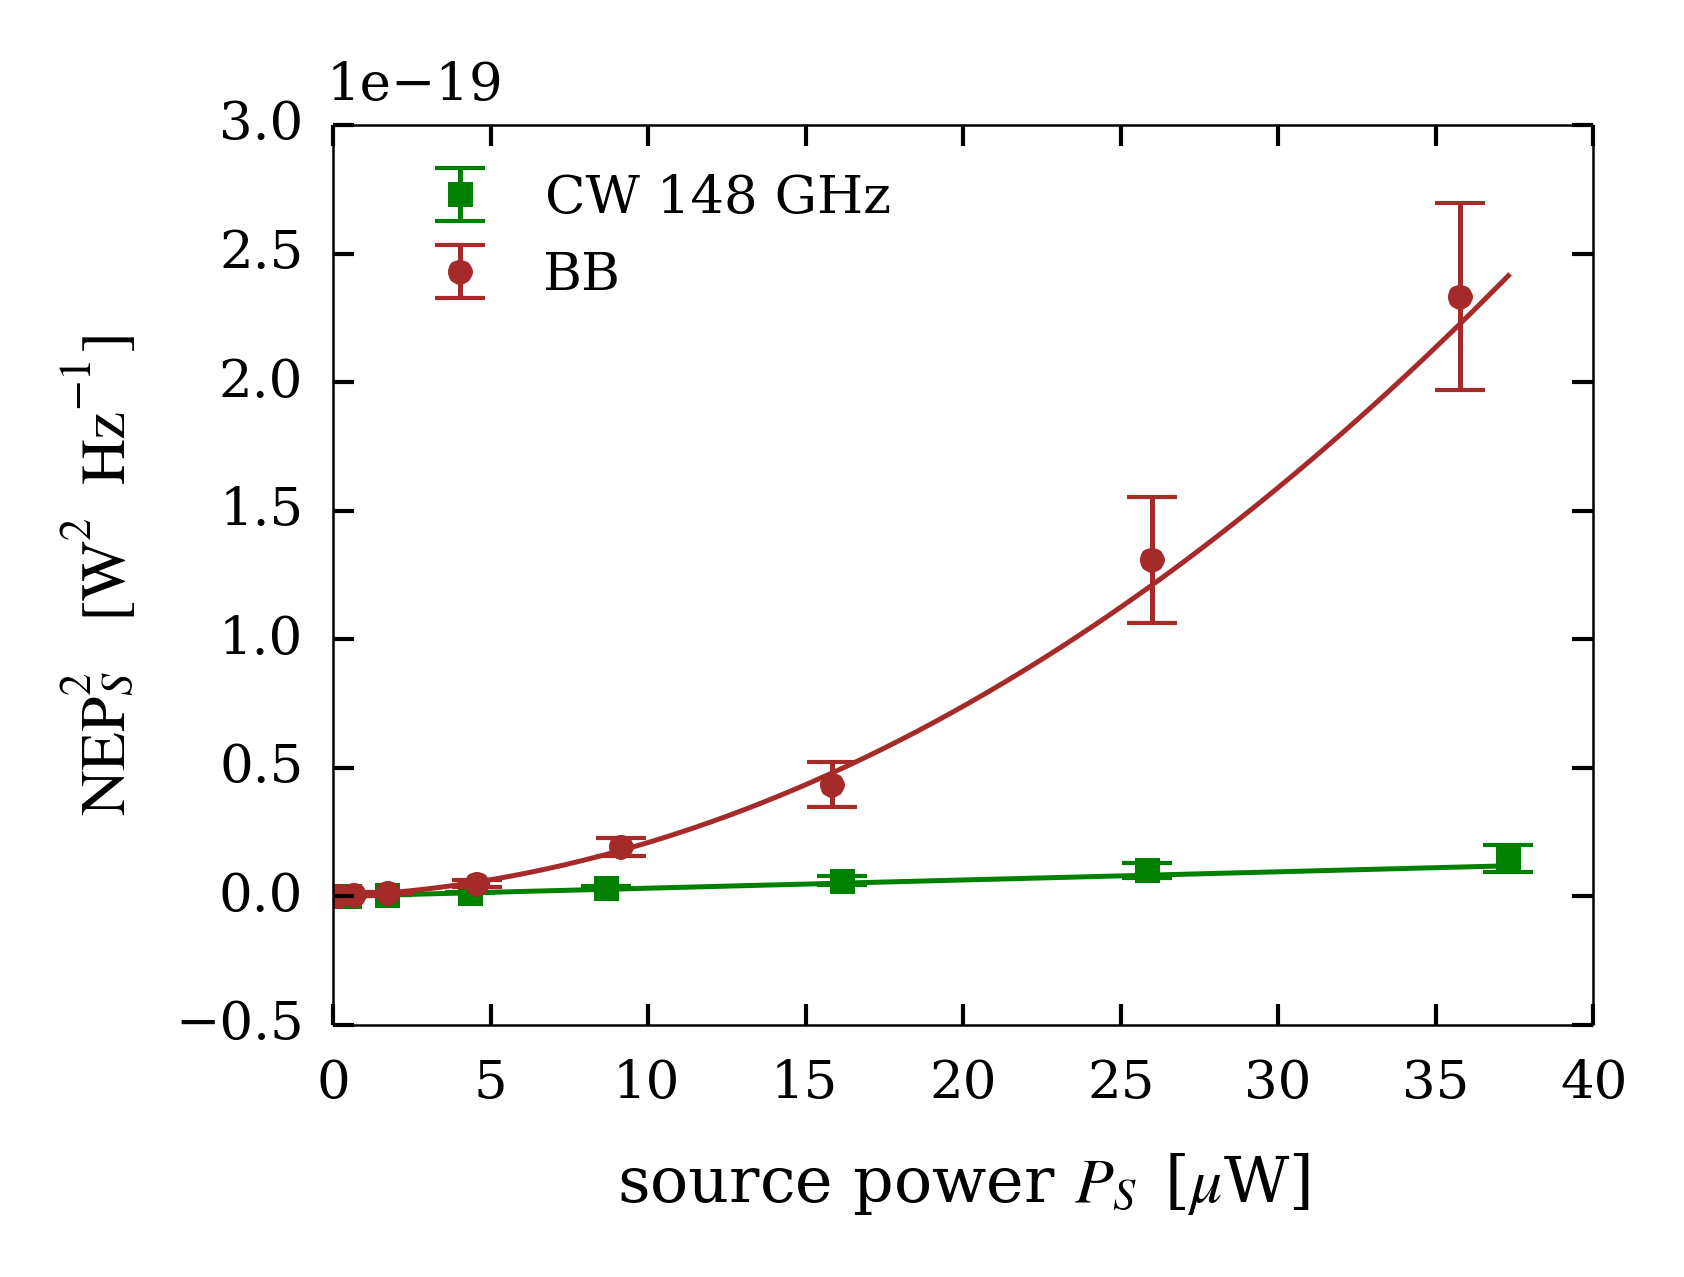

In [28]:
fig, ax = plt.subplots()

PP = 1e-6 * np.linspace(0, 1e6 * max([cw.source_power.max(), bb.source_power.max()]), 1e3)

ax.plot(1e6 * PP,
        np.polyval(cw_poly, PP),
        '-', color=cw_color)

ax.errorbar(1e6 * cw.source_power,
            cw[cw_NEP2_key],
            yerr=cw[cw_NEP2_key+'_err'],
            marker=cw_marker, markersize=markersize, markeredgecolor='none', linestyle='none',
            color=cw_color, label='CW {:.0f} GHz'.format(1e-9 * nu_cw))

ax.plot(1e6 * PP,
        np.polyval(bb_poly, PP),
        '-', color=bb_color)

ax.errorbar(1e6 * bb.source_power,
            bb[bb_NEP2_key],
            yerr=bb[bb_NEP2_key+'_err'],
            marker=bb_marker, markersize=markersize, markeredgecolor='none', linestyle='none',
            color=bb_color, label='BB')

ax.set_xlabel('source power $P_S$ [$\mu$W]')
ax.set_ylabel('$\mathrm{NEP}_S^2 \; [\mathrm{W}^2 \, \mathrm{Hz}^{-1}]$')
ax.legend(loc='best');

#fig.savefig('figures/nep2_bb_{:.0f}_GHz_channel_{:d}_atten_{:.1f}.pdf'.format(nu/1e9, single_channel, atten))

In [29]:
nep_cw = (eta_cw**2 * cw[cw_NEP2_key])**(1/2)
nep_cw_err = nep_cw * (1/2) * (cw[cw_NEP2_key+'_err'] / cw[cw_NEP2_key])
nep_bb = (eta_bb**2 * bb[bb_NEP2_key])**(1/2)
nep_bb_err = nep_bb * (1/2) * (bb[bb_NEP2_key+'_err'] / bb[bb_NEP2_key])

(1e-18, 1e-14)

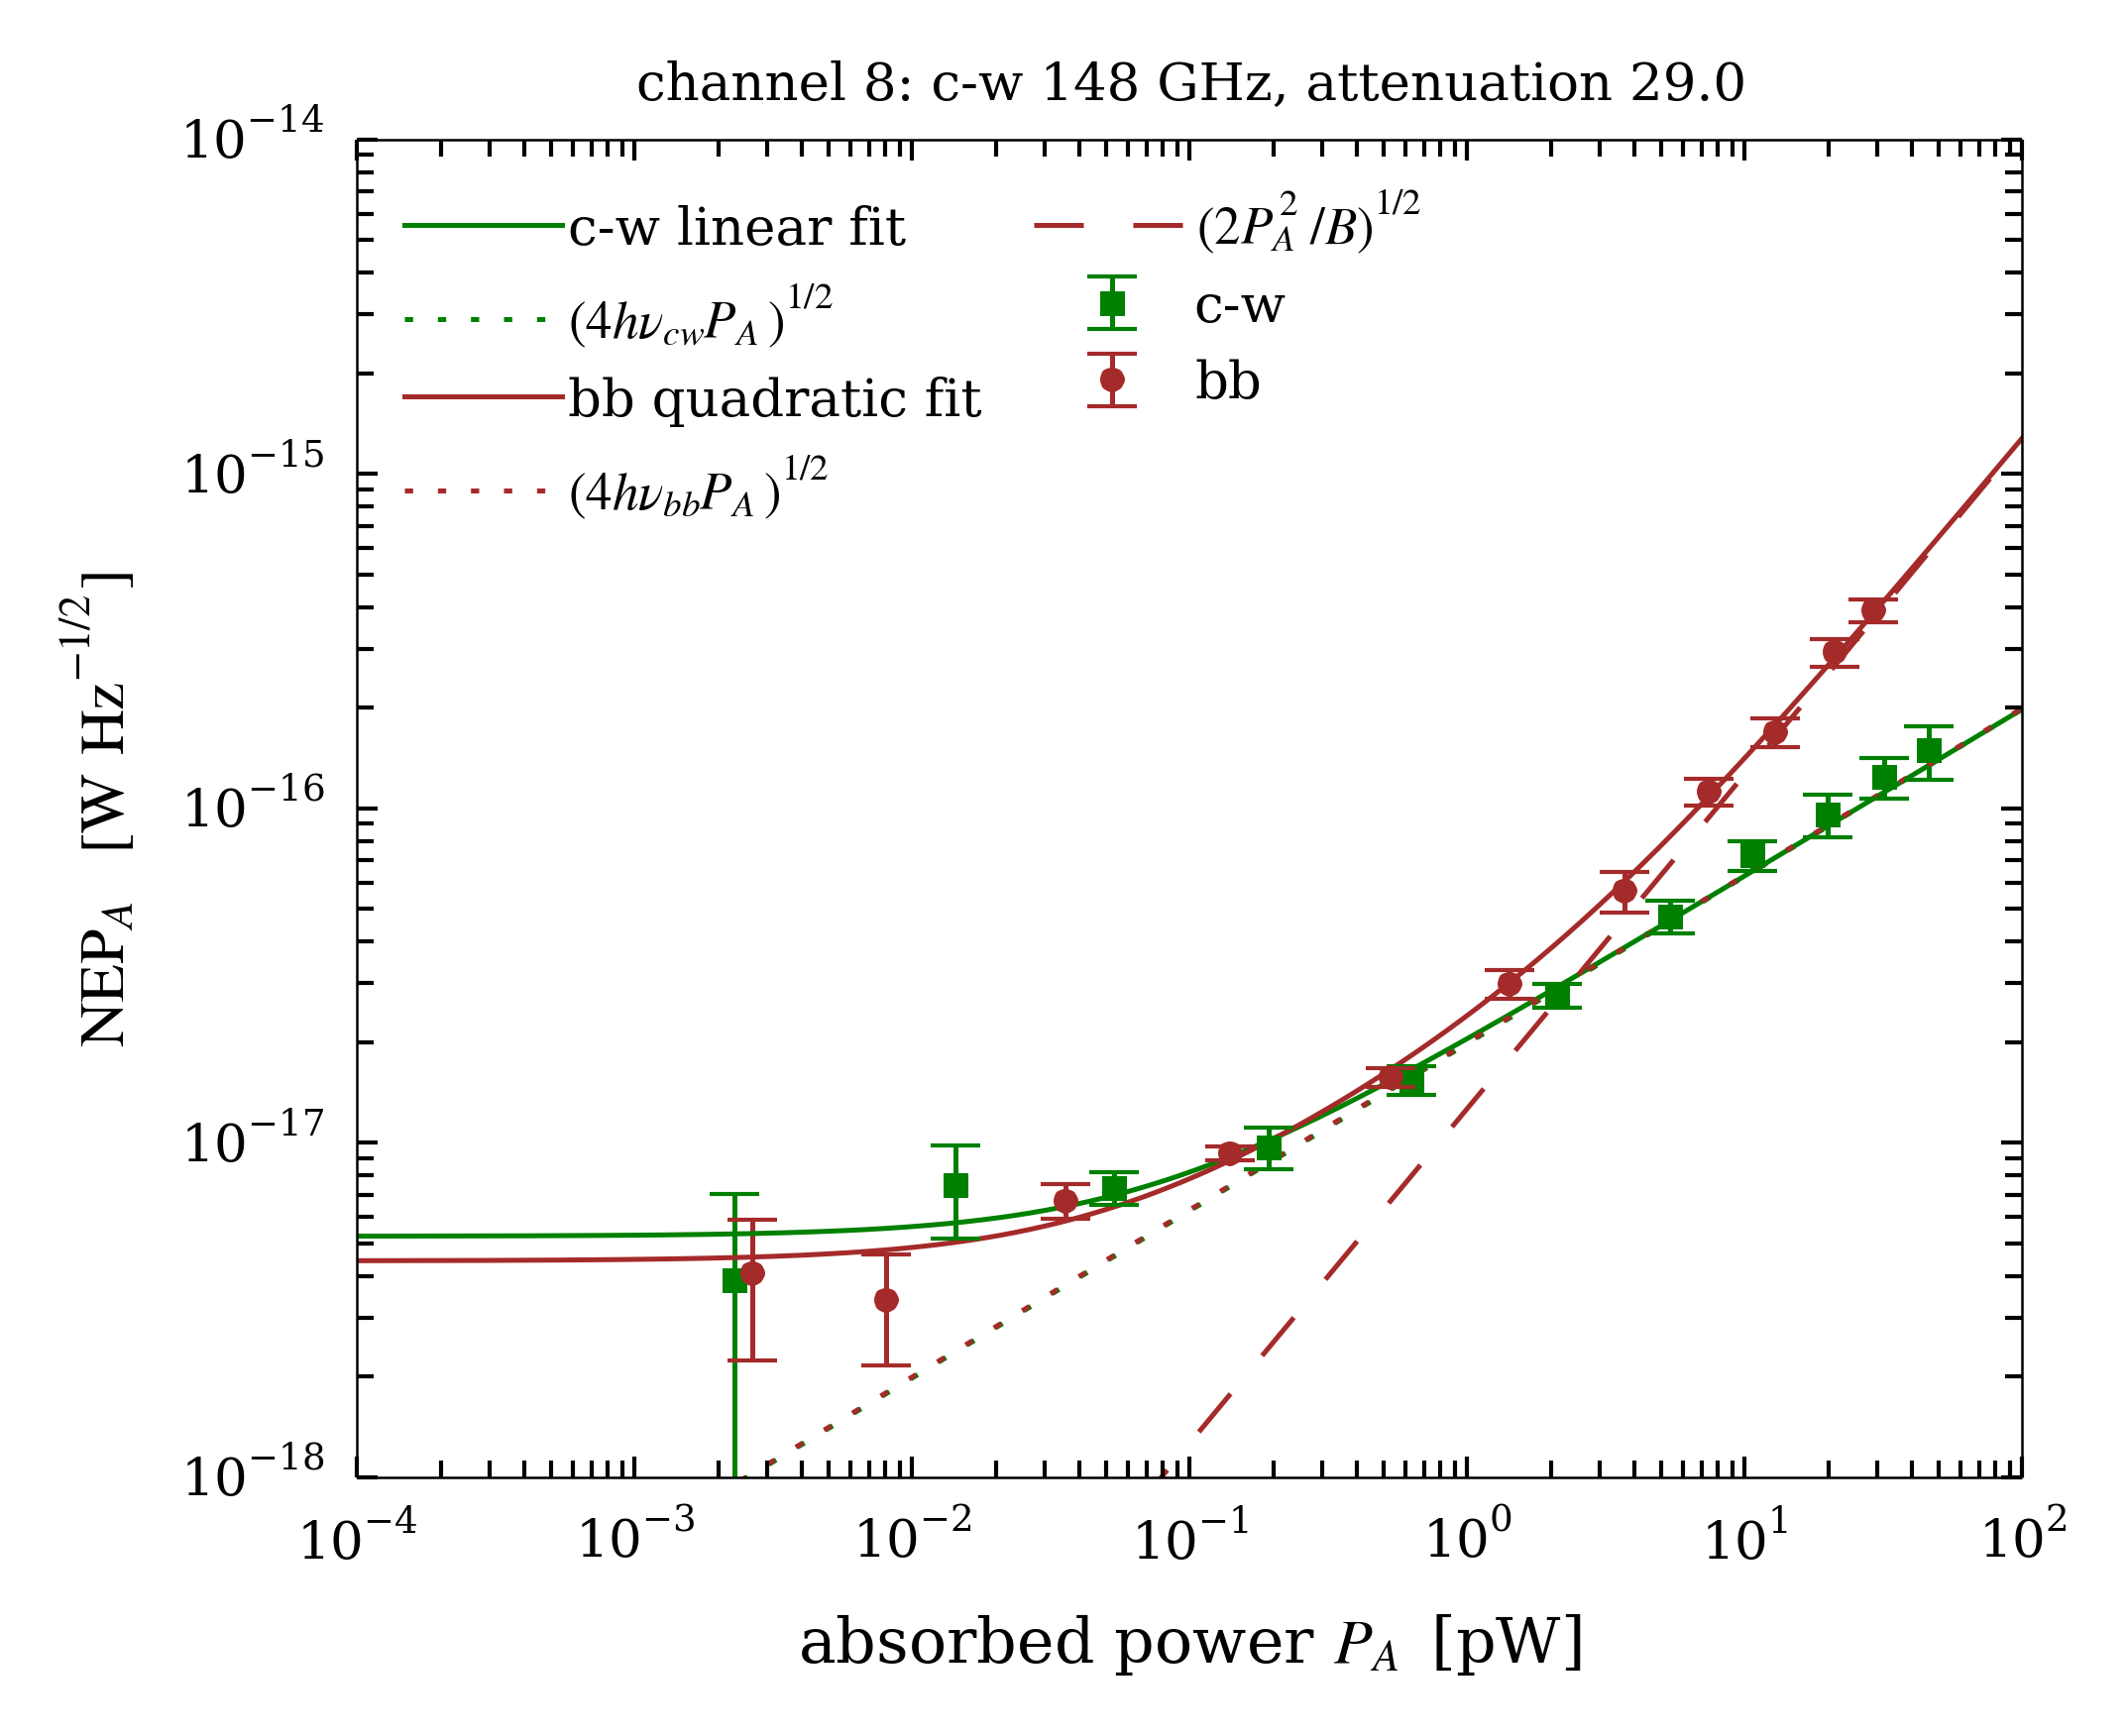

In [30]:
fig, ax = plt.subplots(figsize=(4, 3))

P_source = np.logspace(-11, -2, 1e3)

# c-w
PA_cw = eta_cw * P_source
ax.loglog(PA_scale * PA_cw,
          eta_cw * np.polyval(cw_poly, P_source)**(1/2),
         '-', color=cw_color, label='c-w linear fit')
ax.loglog(PA_scale * eta_cw * P_source,
          (4 * h * nu_cw * eta_cw * P_source)**(1/2),
                ':', color=cw_color, label=r'$(4 h \nu_{cw} P_A)^{1/2}$')

# bb
PA_bb = eta_bb * P_source
ax.loglog(PA_scale * eta_bb * P_source,
          eta_bb * np.polyval(bb_poly, P_source)**(1/2),
          '-', color=bb_color, label='bb quadratic fit')
ax.loglog(PA_scale * eta_bb * P_source,
                (4 * h * nu_bb * eta_bb * P_source)**(1/2),
                ':', color=bb_color, label=r'$(4 h \nu_{bb} P_A)^{1/2}$')
ax.loglog(PA_scale * eta_bb * P_source,
                (2 * (eta_bb * P_source)**2 / B_bb)**(1/2),
                '--', color=bb_color, label=r'$(2 P_A^2 / B)^{1/2}$')
"""
ax.loglog(PA_scale * eta_bb * P_source,
                (4 * h * nu_bb * PA_bb + 2 * PA_bb**2 / B_bb)**(1/2),
                '-', color=bb_color, label=r'$(4 h \nu_{bb} P_A + 2 P_A^2 / B)^{1/2}$')
"""

ax.errorbar(1e12 * eta_cw * cw.source_power,
            nep_cw,
            yerr=nep_cw_err,
            marker=cw_marker, markersize=markersize, markeredgecolor='none', linestyle='none',
            color=cw_color, label='c-w')

ax.errorbar(1e12 * eta_bb * bb.source_power,
            nep_bb,
            yerr=nep_bb_err,
            marker=bb_marker, markersize=markersize, markeredgecolor='none', linestyle='none',
            color=bb_color, label='bb')

ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('$\mathrm{NEP}_A \; [\mathrm{W} \, \mathrm{Hz}^{-1/2}]$')

ax.legend(loc='upper left', fontsize='xx-small', ncol=2)
ax.set_title('channel {:d}: c-w {:.0f} GHz, attenuation {:.1f}'.format(single_channel, 1e-9 * nu_cw, atten), fontsize='xx-small');
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(1e-18, 1e-14)

#fig.savefig('nep/nep_channel_{:d}_bb_and_{:.0f}_GHz_atten_{:.1f}.pdf'.format(single_channel, 1e-9 * nu_cw, atten))

AttributeError: 'DataFrame' object has no attribute 'source_power_fd_NEP2_TLS'

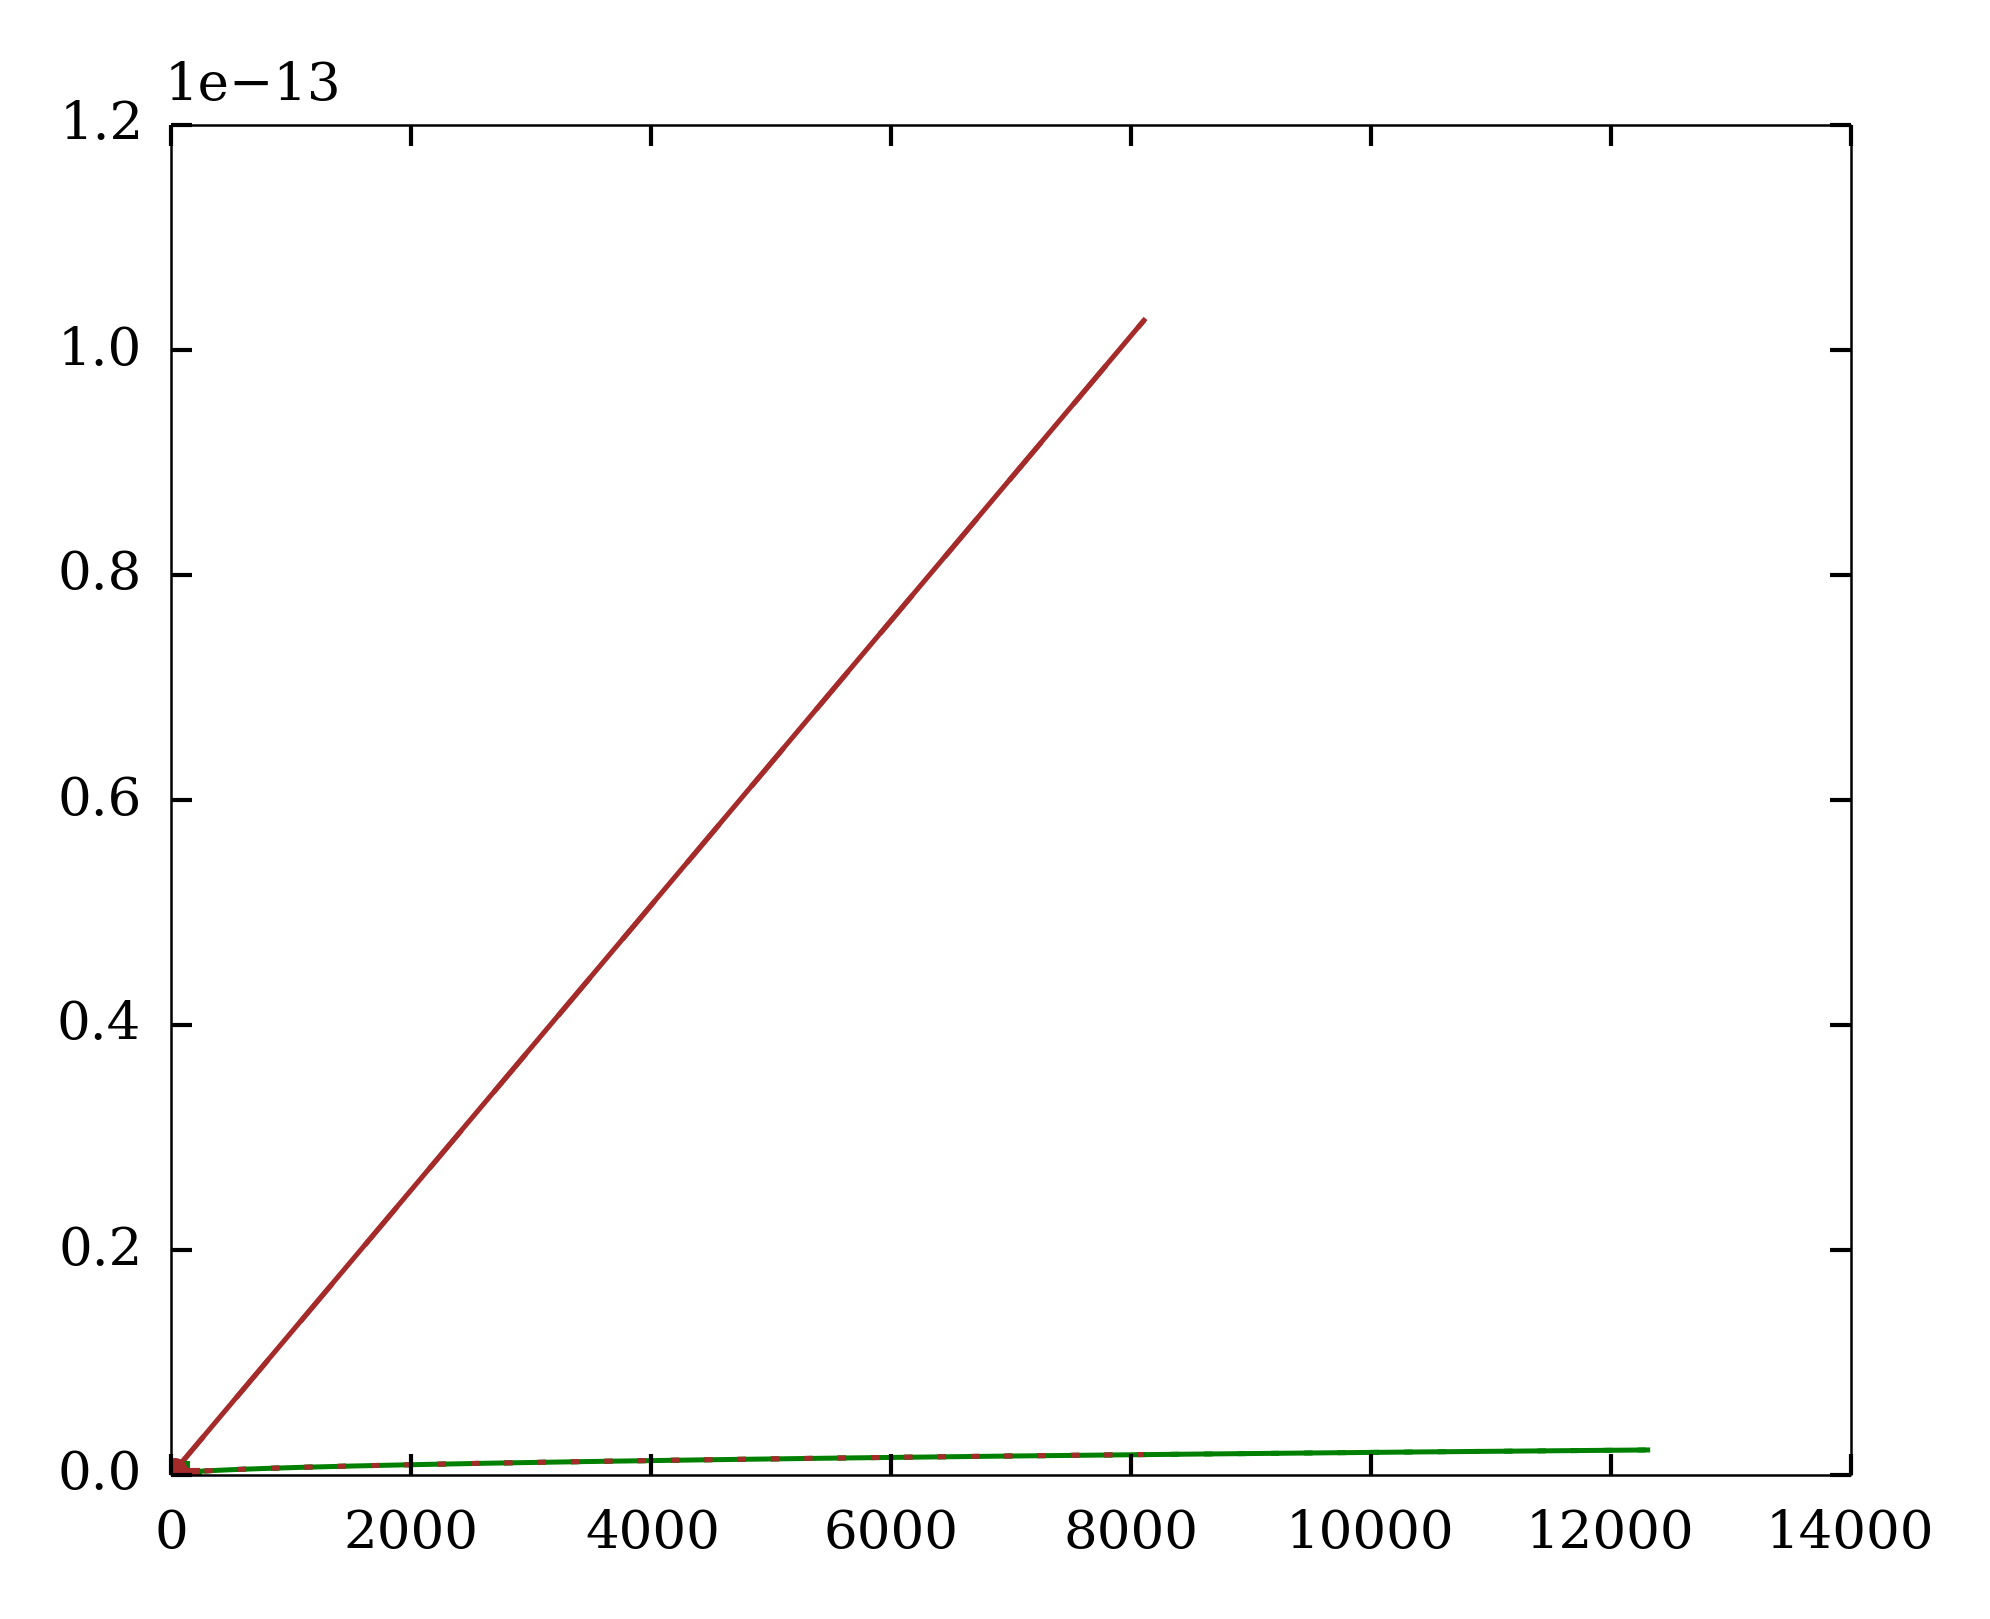

In [31]:
fig, ax = plt.subplots(figsize=(4, 3))

P_source = np.logspace(-11, -2, 1e3)

# c-w
PA_cw = eta_cw * P_source
ax.plot(PA_scale * PA_cw,
          eta_cw * np.polyval(cw_poly, P_source)**(1/2),
         '-', color=cw_color, label='c-w linear fit')
ax.plot(PA_scale * PA_cw,
          (4 * h * nu_cw * PA_cw)**(1/2),
                ':', color=cw_color, label=r'$(4 h \nu_{cw} P_A)^{1/2}$')

# bb
PA_bb = eta_bb * P_source
ax.plot(PA_scale * PA_bb,
          eta_bb * np.polyval(bb_poly, P_source)**(1/2),
          '-', color=bb_color, label='bb quadratic fit')
ax.plot(PA_scale * PA_bb,
                (4 * h * nu_bb * eta_bb * P_source)**(1/2),
                ':', color=bb_color, label=r'$(4 h \nu_{bb} P_A)^{1/2}$')
ax.plot(PA_scale * PA_bb,
                (2 * (eta_bb * P_source)**2 / B_bb)**(1/2),
                '--', color=bb_color, label=r'$(2 P_A^2 / B)^{1/2}$')
"""
ax.plot(PA_scale * eta_bb * P_source,
                (4 * h * nu_bb * PA_bb + 2 * PA_bb**2 / B_bb)**(1/2),
                '-', color=bb_color, label=r'$(4 h \nu_{bb} P_A + 2 P_A^2 / B)^{1/2}$')
"""

ax.errorbar(PA_scale * eta_cw * cw.source_power,
            nep_cw,
            yerr=nep_cw_err,
            marker=cw_marker, markersize=markersize, markeredgecolor='none', linestyle='none',
            color=cw_color, label='c-w')

ax.errorbar(PA_scale * eta_bb * bb.source_power,
            nep_bb,
            yerr=nep_bb_err,
            marker=bb_marker, markersize=markersize, markeredgecolor='none', linestyle='none',
            color=bb_color, label='bb')

# TLS
ax.plot(PA_scale * eta_bb * bb.source_power,
        eta_bb * bb.source_power_fd_NEP2_TLS**(1/2), '.k')
        
ax.plot(PA_scale * eta_cw * cw.source_power,
        eta_cw * cw.source_power_fd_NEP2_TLS**(1/2), '.', color='gray')

PS_tls = np.logspace(np.log10(np.min(bb.source_power)),
                     np.log10(np.max(bb.source_power)),
                     1e3)
tls_poly = np.polyfit(bb.source_power, bb.source_power_fd_NEP2_TLS, 3)
ax.plot(PA_scale * eta_bb * PS_tls,
        eta_bb * np.polyval(tls_poly, PS_tls)**(1/2), '-k')

ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('absorbed power $P_A$ [pW]')
ax.set_ylabel('$\mathrm{NEP}_A \; [\mathrm{W} \, \mathrm{Hz}^{-1/2}]$')

ax.legend(loc='upper left', fontsize='xx-small', ncol=2)
ax.set_title('channel {:d}: c-w {:.0f} GHz, attenuation {:.1f}'.format(single_channel, 1e-9 * nu_cw, atten), fontsize='xx-small');
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(1e-18, 5e-16)

#fig.savefig('nep/nep_channel_{:d}_bb_and_{:.0f}_GHz_atten_{:.1f}.pdf'.format(single_channel, 1e-9 * nu_cw, atten))

In [ ]:
PA_scale * PA_bb.max()

In [ ]:
fig, ax = plt.subplots()
# TLS
ax.loglog(PA_scale * eta_bb * bb.source_power,
        eta_bb * bb.source_power_fd_NEP2_TLS**(1/2), '.k')
        
ax.plot(PA_scale * eta_cw * cw.source_power,
        eta_cw * cw.source_power_fd_NEP2_TLS**(1/2), '.', color='gray')
tls_poly = np.polyfit(bb.source_power, bb.source_power_fd_NEP2_TLS, 3)
ax.plot(PA_scale * PA_bb,
        eta_bb * np.polyval(tls_poly, P_source)**(1/2), '-k')

ax.plot(PA_scale * PA_bb,
        1.1e-11 * PA_bb**(1/2), '--k')
ax.set_ylim(0, 1e-16)
ax.set_xlim(0, 100)

## Response fits

In [ ]:
fig, X_ax, I_ax = plot_dataframe.plot_response(cw, 'source_power', ncols=1, nrows=1, figsize=(2, 2), loglog=True)
#                                                   P_limits=(1e-4, 1e-1), X_limits=(1e-2, 1e1), I_limits=(1e-1, 1e1))

In [ ]:
fig, X_ax, I_ax = plot_dataframe.plot_response(bb, 'source_power', ncols=1, nrows=1, figsize=(2, 2), loglog=True)

In [ ]:
fig, ax = plt.subplots()

X_scale = 1e6
P_scale = 1e12

fit_values = np.logspace(np.log10(bb.source_power.min() / 3), np.log10(3 * bb.source_power.max()), 1e3)
ax.plot(P_scale * eta_bb * fit_values, 2e2 * P_scale * eta_bb * fit_values,
        '--', color='gray', label='$P^1$')
ax.plot(P_scale * eta_bb * fit_values, 2e2 * (P_scale * eta_bb * fit_values)**(1/2),
        '--', color='black', label='$P^{1/2}$')

for group, eta, color, label in zip([cw, bb], [eta_cw, eta_bb], [cw_color, bb_color], ['cw', 'bb']):
    ax.errorbar(P_scale * eta * group.source_power,
                X_scale * group.source_power_X,
                yerr=X_scale * group.source_power_X_err,
                marker='.', linestyle='none', color=color, label=label)
    value = 'source_power'
    P_0 = group['{}_fit_P_0'.format(value)].iloc[0]
    P_star = group['{}_fit_P_star'.format(value)].iloc[0]
    X_0 = group['{}_fit_X_0'.format(value)].iloc[0]
    I_0 = group['{}_fit_I_0'.format(value)].iloc[0]
    I_C = group['{}_fit_I_C'.format(value)].iloc[0]
    ax.plot(P_scale * eta * fit_values, X_scale * dataframe.X(fit_values, P_0, P_star, X_0), color=color)

ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
ax.legend(loc='best', fontsize='x-small')
ax.set_xlabel('absorbed source power [pW]')
ax.set_ylabel(r'$10^6 \, x$');

In [ ]:
fig, ax = plt.subplots()
ax.plot(1e6 * bb.source_power, bb.source_power_fit_dX_dP, '-', color='blue')
ax.errorbar(1e6 * bb.source_power, bb.source_power_fd_dX_dP, yerr=bb.source_power_fd_dX_dP_err,
            marker='.', linestyle='none', color='cyan')
ax.plot(1e6 * cw.source_power, cw.source_power_fit_dX_dP, '-', color='red')
ax.errorbar(1e6 * cw.source_power, cw.source_power_fd_dX_dP, yerr=cw.source_power_fd_dX_dP_err,
            marker='.', linestyle='none', color='orange')
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')
#ax.set_ylim(0, 300)

In [ ]:
fig, ax = plot_dataframe.plot_pca_noise(off, single_channel, plot_row_0=False, plot_fit=True)
#ax.set_ylim(1e-18, 1e-16)
ax.set_xlim(1e0, 1e4)
ax.set_title("")
ax.set_ylabel(r"$S_x \, [\mathrm{Hz}^{-1}]$")
ax.set_xlabel("frequency [Hz]");

fig.savefig('figures/S_x_TLS_dark_channel_{:d}.pdf'.format(single_channel))

## TLS

In [ ]:
P_i_dark = off[off.channel==single_channel].readout_power_internal.iloc[0]

In [ ]:
fig, ax = plt.subplots()
ax.plot(bb.source_power, (P_i_dark / bb.readout_power_internal)**(1/2), '.')
ax.plot(cw.source_power, (P_i_dark / cw.readout_power_internal)**(1/2), '.')
ax.set_xscale('log')

In [ ]:
bb_turns = 4
bb_mask = bb.mmw_atten_total_turns/2==bb_turns

In [ ]:
cw_turns = 4
cw_mask = cw.mmw_atten_total_turns/2==cw_turns

In [ ]:
fig, ax = plot_dataframe.plot_pca_noise(bb[bb_mask], single_channel)
fr = bb[bb_mask].pca_freq.iloc[0]
S1Hz = 1e-17
ax.plot(fr, ((S1Hz * fr**(-1/2) * (P_i_dark / bb[bb_mask].readout_power_internal.iloc[0])**(1/2) /
              (1 + (fr / bb[bb_mask].noise_fit_fc.iloc[0])**2)) +
             bb[bb_mask].noise_fit_amplifier_noise.iloc[0]),
        '-k')

In [ ]:
fig, ax = plot_dataframe.plot_pca_noise(cw[cw_mask], single_channel, plot_fit=True)
fr = cw[cw_mask].pca_freq.iloc[0]
S1Hz = 1e-17
ax.plot(fr, ((S1Hz * fr**(-1/2) * (P_i_dark / cw[cw_mask].readout_power_internal.iloc[0])**(1/2) /
              (1 + (fr / cw[cw_mask].noise_fit_fc.iloc[0])**2)) +
             cw[cw_mask].noise_fit_amplifier_noise.iloc[0]),
        '-k')
ax.plot(fr, 0.8e-15 * fr**-1, '--r')

## Amplifier noise

In [ ]:
fig, ax = plt.subplots()

for index, row in bb.iterrows():
    ax.semilogx(1e6 * row.source_power,
            row.noise_fit_amplifier_noise / row.pca_eigvals[0][-30:].mean(), '.', color=bb_color)

for index, row in cw.iterrows():
    ax.semilogx(1e6 * row.source_power,
            row.noise_fit_amplifier_noise / row.pca_eigvals[0][-30:].mean(), '.', color=cw_color)

In [ ]:
bb['amplitude_noise'] = np.nan
for index, row in bb.iterrows():
    bb.loc[index, 'amplitude_noise'] = row.pca_eigvals[0][-30:].mean()
bb['device_noise_corrected'] = bb.noise_fit_device_noise + (bb.noise_fit_amplifier_noise - bb.amplitude_noise)
bb['source_power_fd_NEP2_device_corrected'] = bb.device_noise_corrected / bb.source_power_fd_dX_dP**2

In [ ]:
fig, ax = plot_dataframe.plot_pca_noise(bb[bb_mask], bb.channel.iloc[0], plot_fit=True)
ax.axhline(bb[bb_mask].noise_fit_amplifier_noise.iloc[0], color='blue')
ax.axhline(bb[bb_mask].amplitude_noise.iloc[0], color='gray')
ax.axhline(bb[bb_mask].device_noise_corrected.iloc[0], color='red')

In [ ]:
fig, ax = plt.subplots()

for index, row in bb.iterrows():
    ax.semilogx(1e6 * row.source_power,
                row.noise_fit_device_noise,
                'o', color=bb_color, markeredgecolor='none')

for index, row in bb.iterrows():
    ax.semilogx(1e6 * row.source_power,
                row.noise_fit_amplifier_noise,
                's', color=bb_color, markeredgecolor='none')

ax.plot(1e6 * bb.source_power,
        bb.amplitude_noise,
        '.b')

ax.plot(1e6 * bb.source_power,
        bb.device_noise_corrected,
        '.r')


In [ ]:
cw['amplitude_noise'] = np.nan
for index, row in cw.iterrows():
    cw.loc[index, 'amplitude_noise'] = row.pca_eigvals[0][-30:].mean()
cw['device_noise_corrected'] = cw.noise_fit_device_noise + (cw.noise_fit_amplifier_noise - cw.amplitude_noise)
cw['source_power_fd_NEP2_device_corrected'] = cw.device_noise_corrected / cw.source_power_fd_dX_dP**2

In [ ]:
fig, ax = plt.subplots()

for index, row in cw.iterrows():
    ax.semilogx(1e6 * row.source_power,
                row.noise_fit_device_noise,
                'o', color=cw_color, markeredgecolor='none')

for index, row in cw.iterrows():
    ax.semilogx(1e6 * row.source_power,
                row.noise_fit_amplifier_noise,
                's', color=cw_color, markeredgecolor='none')

ax.plot(1e6 * cw.source_power,
        cw.amplitude_noise,
        '.b')

ax.plot(1e6 * cw.source_power,
        cw.device_noise_corrected,
        '.r')